# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Preparing-Test-Data" data-toc-modified-id="Preparing-Test-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Test Data</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Fitting-GP-on-training-data" data-toc-modified-id="Fitting-GP-on-training-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting GP on training data</a></div><div class="lev2 toc-item"><a href="#Predicting-at-the-test-location" data-toc-modified-id="Predicting-at-the-test-location-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predicting at the test location</a></div><div class="lev2 toc-item"><a href="#Prior-draws" data-toc-modified-id="Prior-draws-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Prior draws</a></div><div class="lev2 toc-item"><a href="#Predictive-draws" data-toc-modified-id="Predictive-draws-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Predictive draws</a></div><div class="lev2 toc-item"><a href="#Diagnostic-measures" data-toc-modified-id="Diagnostic-measures-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Diagnostic measures</a></div><div class="lev1 toc-item"><a href="#STAN-imputations" data-toc-modified-id="STAN-imputations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>STAN imputations</a></div><div class="lev2 toc-item"><a href="#Model-specification" data-toc-modified-id="Model-specification-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model specification</a></div><div class="lev2 toc-item"><a href="#preparing-Stan-data" data-toc-modified-id="preparing-Stan-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>preparing Stan data</a></div><div class="lev2 toc-item"><a href="#Running-MCMC" data-toc-modified-id="Running-MCMC-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Running MCMC</a></div><div class="lev2 toc-item"><a href="#Plotting-imputations" data-toc-modified-id="Plotting-imputations-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plotting imputations</a></div><div class="lev2 toc-item"><a href="#Changed-softmax-definition" data-toc-modified-id="Changed-softmax-definition-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Changed softmax definition</a></div>

$$
    \newcommand{\genericdel}[3]{%
      \left#1#3\right#2
    }
    \newcommand{\del}[1]{\genericdel(){#1}}
    \newcommand{\sbr}[1]{\genericdel[]{#1}}
    \newcommand{\cbr}[1]{\genericdel\{\}{#1}}
    \newcommand{\abs}[1]{\genericdel||{#1}}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \DeclareMathOperator{\Pr}{\mathbb{p}}
    \DeclareMathOperator{\E}{\mathbb{E}}
    \DeclareMathOperator{\Ind}{\mathbb{I}}
    \DeclareMathOperator{\var}{var}
    \DeclareMathOperator{\cov}{cov}
    \DeclareMathOperator{\invchi}{\mathrm{Inv-\chi}^2}
    \DeclareMathOperator*{\argmin}{arg\,min}
    \DeclareMathOperator*{\argmax}{arg\,max}
    \newcommand{\effect}{\mathrm{eff}}
    \newcommand{\xtilde}{\widetilde{X}}
    \DeclareMathOperator{\normal}{\mathcal{N}}
    \DeclareMathOperator{\unif}{Uniform}
    \DeclareMathOperator{\GP}{\mathcal{GP}}
    \DeclareMathOperator{\l}{\mathscr{l}}
    \newcommand{\Tn}{\mathrm{T}_{n}}
    \newcommand{\Tx}{\mathrm{T}_{x}}
$$

Going back to basics: using the product of squared exponentials (kernel obtained in `JuliaGP_spatial2.ipynb`).

In [3]:
using Stan

using TimeSeries
using DataFrames
using GaussianProcesses
using GaussianProcesses: Mean, Kernel, evaluate, metric, IsotropicData, VecF64
using GaussianProcesses: Stationary, KernelData, MatF64, predict
import GaussianProcesses: optimize!, get_optim_target, cov, grad_slice!
import GaussianProcesses: num_params, set_params!, get_params, update_mll!, update_mll_and_dmll!
import GaussianProcesses: get_param_names, cov!, addcov!, multcov!
import Proj4
using Optim
using Distances
using DataFrames: by, head
using Dates: tonext, Hour, Day
;

In [4]:
import PyPlot; plt=PyPlot
using LaTeXStrings
plt.rc("figure", dpi=300.0)
plt.rc("figure", figsize=(12,8))
plt.rc("savefig", dpi=300.0)
plt.rc("text", usetex=true)
plt.rc("font", family="serif")
plt.rc("font", serif="Palatino")
;

# Data import and preprocessing

In [5]:
include("src/preprocessing.jl")
include("src/variogram.jl")
include("src/utils.jl")

measurement_date (generic function with 1 method)

In [6]:
isdList=read_isdList()
isdSubset=isdList[[(usaf in (725450,725460,725480,725485)) for usaf in isdList[:USAF].values],:]
isdSubset

4×13 DataFrames.DataFrame
│ Row │ USAF   │ WBAN  │ NAME                             │ CTRY │ STATE │
├─────┼────────┼───────┼──────────────────────────────────┼──────┼───────┤
│ 1   │ 725450 │ 14990 │ THE EASTERN IOWA AIRPORT         │ US   │ IA    │
│ 2   │ 725460 │ 14933 │ DES MOINES INTERNATIONAL AIRPORT │ US   │ IA    │
│ 3   │ 725480 │ 94910 │ WATERLOO MUNICIPAL AIRPORT       │ US   │ IA    │
│ 4   │ 725485 │ 14940 │ MASON CITY MUNICIPAL ARPT        │ US   │ IA    │

│ Row │ ICAO │ LAT    │ LON     │ ELEV  │ BEGIN │ END  │ X_PRJ     │ Y_PRJ     │
├─────┼──────┼────────┼─────────┼───────┼───────┼──────┼───────────┼───────────┤
│ 1   │ KCID │ 41.883 │ -91.717 │ 264.6 │ 1973  │ 2015 │ 1.64799e6 │ 1.0441e6  │
│ 2   │ KDSM │ 41.534 │ -93.653 │ 291.7 │ 1973  │ 2015 │ 1.48723e6 │ 1.00379e6 │
│ 3   │ KALO │ 42.554 │ -92.401 │ 264.6 │ 1960  │ 2015 │ 1.59025e6 │ 1.11766e6 │
│ 4   │ KMCW │ 43.154 │ -93.327 │ 373.4 │ 1973  │ 2015 │ 1.51407e6 │ 1.18374e6 │

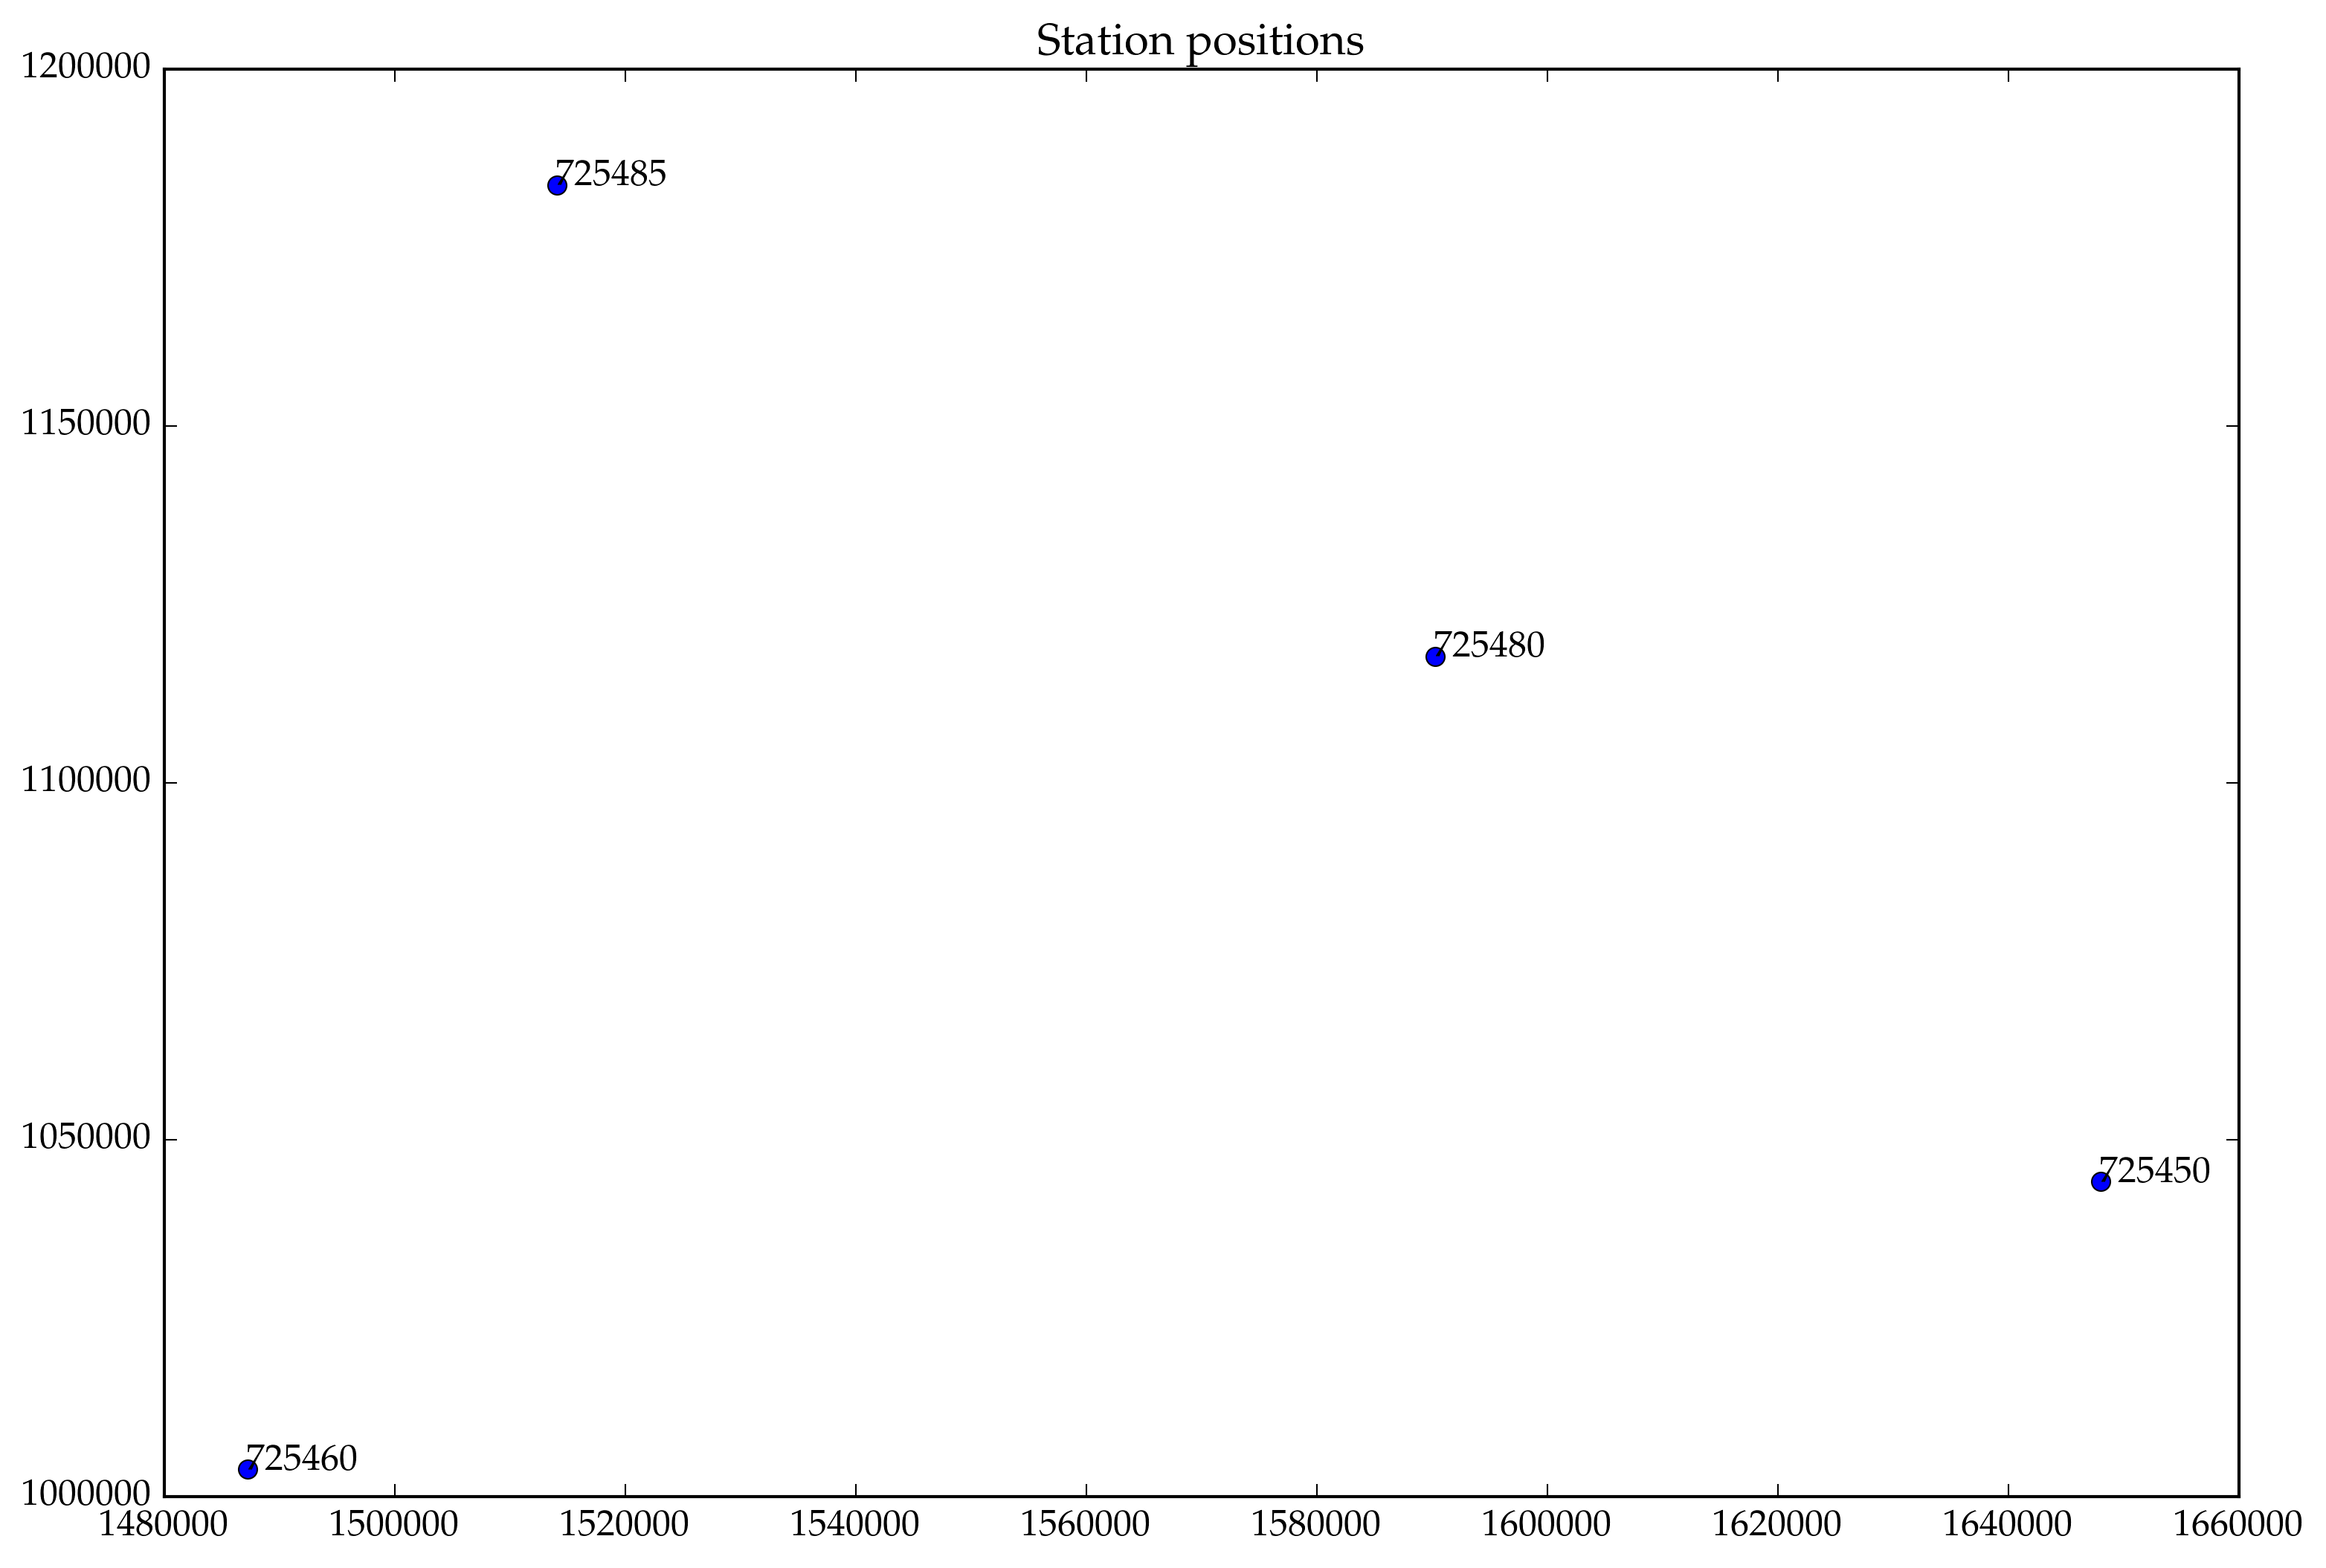

In [7]:
plt.plot(isdSubset[:X_PRJ].values, isdSubset[:Y_PRJ].values, "o")
for r in eachrow(isdSubset)
    plt.text(get(r[:X_PRJ]), get(r[:Y_PRJ]), get(r[:USAF]))
end
plt.title("Station positions")
;

In [8]:
hourly_cat=read_Stations(isdSubset)
itest=3
hourly_train = hourly_cat[hourly_cat[:station].values.!=itest,:]
hourly_test  = hourly_cat[hourly_cat[:station].values.==itest,:]
nrow(hourly_train), nrow(hourly_test)

(35169,12695)

# Preparing Test Data

In [9]:
hr_measure = Hour(17) # number between 0 and 24
hourly_test[:ts_day] = [measurement_date(t, hr_measure) for t in hourly_test[:ts].values]
TnTx = DataFrames.by(hourly_test, :ts_day, df -> DataFrame(
    Tn=minimum(df[:temp].values), 
    Tx=maximum(df[:temp].values)))
test_trimmed=join(hourly_test, TnTx, on=:ts_day)
head(test_trimmed)

6×13 DataFrames.DataFrame
│ Row │ year │ month │ day │ hour │ min │ seconds │ temp  │
├─────┼──────┼───────┼─────┼──────┼─────┼─────────┼───────┤
│ 1   │ 2015 │ 1     │ 1   │ 0    │ 0   │ 0       │ -8.3  │
│ 2   │ 2015 │ 1     │ 1   │ 0    │ 54  │ 0       │ -8.9  │
│ 3   │ 2015 │ 1     │ 1   │ 1    │ 54  │ 0       │ -8.9  │
│ 4   │ 2015 │ 1     │ 1   │ 2    │ 54  │ 0       │ -9.4  │
│ 5   │ 2015 │ 1     │ 1   │ 3    │ 54  │ 0       │ -9.4  │
│ 6   │ 2015 │ 1     │ 1   │ 4    │ 54  │ 0       │ -10.0 │

│ Row │ ts                  │ station │ ts_hours │ ts_day     │ Tn    │ Tx   │
├─────┼─────────────────────┼─────────┼──────────┼────────────┼───────┼──────┤
│ 1   │ 2015-01-01T00:00:00 │ 3       │ 0.0      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 2   │ 2015-01-01T00:54:00 │ 3       │ 0.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 3   │ 2015-01-01T01:54:00 │ 3       │ 1.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 4   │ 2015-01-01T02:54:00 │ 3       │ 2.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 5   │ 2015-01-01T03:54:00 │ 3       │ 3.9      │ 2015-01-01 │ -11.1 │ -3.9 │
│ 6   │ 2015-01-01T04:54:00 │ 3       │ 4.9      │ 2015-01-01 │ -11.1 │ -3.9 │

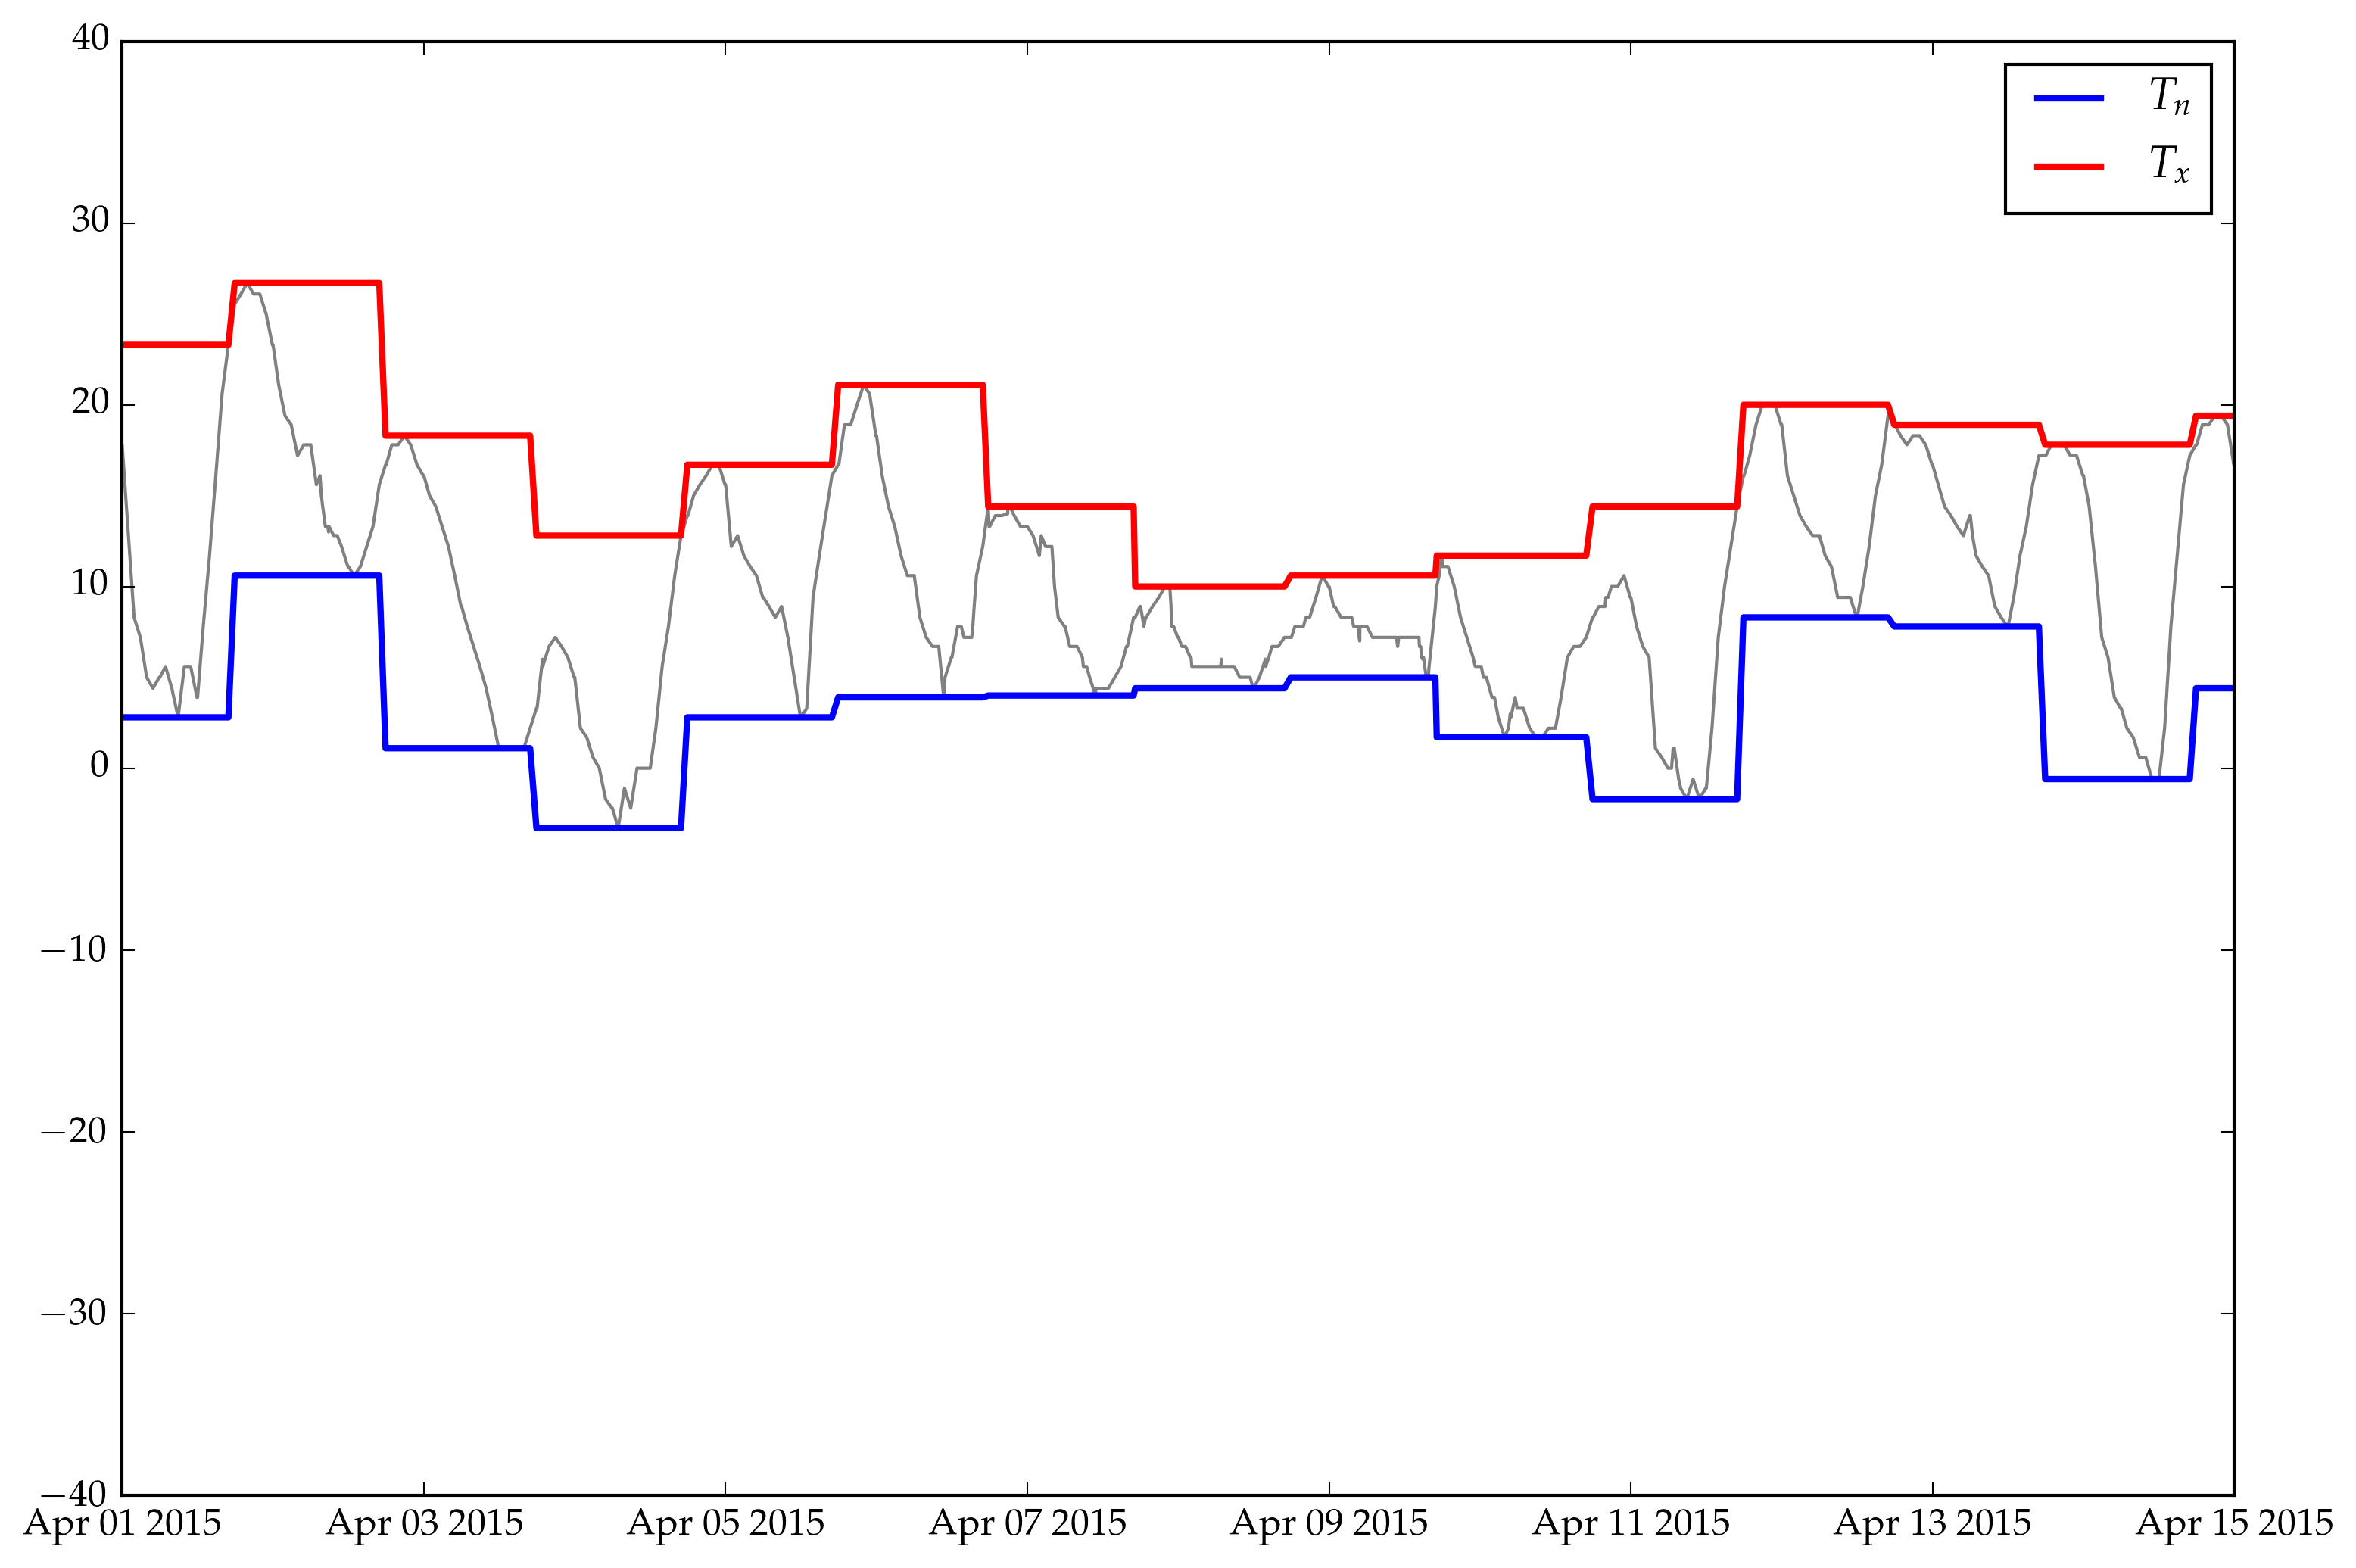

In [10]:
plt.plot(test_trimmed[:ts].values, test_trimmed[:temp].values, color="grey")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tn].values, color="blue", linewidth=2, label=L"$T_n$")
plt.plot(test_trimmed[:ts].values, test_trimmed[:Tx].values, color="red", linewidth=2, label=L"$T_x$")
plt.xlim(DateTime(2015,4,1),DateTime(2015,4,15)) # random interval
plt.legend()
;

# Kernel Specification

In [11]:
k_time = SEIso(0.0,0.0)
k_spatial = fix(SEIso(log(2*10^5), log(1.0)), :lσ)
k_means = SEIso(log(10^4), log(10.0))
k_spatiotemporal = Masked(k_time, [1]) * Masked(k_spatial, [2,3]) + 
    fix(Masked(k_means, [2,3]))
hyp = [-0.822261,0.996834,1.3172,12.0805]
set_params!(k_spatiotemporal, hyp[2:end])
logNoise=hyp[1]

-0.822261

In [12]:
print("\nk: Temporal kernel \n=================\n")
@printf("σ: %5.3f\n", √k_time.σ2)
@printf("l: %5.3f hours\n", √k_time.ℓ2)
print("\nk: Spatial kernel \n=================\n")
@printf("σ: %5.3f\n", √k_spatial.kern.σ2)
@printf("l: %5.3f meters\n", √k_spatial.kern.ℓ2)
print("\n=================\n")
@printf("σy: %5.3f\n", exp(reals.logNoise))


k: Temporal kernel 
σ: 3.733
l: 2.710 hours

k: Spatial kernel 
σ: 1.000
l: 176398.338 meters



LoadError: UndefVarError: reals not defined

# Fitting GP on training data

In [13]:
function subset(df, from, to)
    after_from = df[:ts].values .>= from
    before_to = df[:ts].values .<= to
    return df[after_from & before_to,:]
end

train_subset = subset(hourly_train,DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0))
avgtemp=by(train_subset, :station, df->DataFrame(avgtemp=mean(df[:temp].values)))
train_subset = join(train_subset, avgtemp, on=:station)

train_X_PRJ = isdSubset[:X_PRJ].values[train_subset[:station].values]
train_Y_PRJ = isdSubset[:Y_PRJ].values[train_subset[:station].values]
train_X = [train_subset[:ts_hours].values train_X_PRJ train_Y_PRJ]
train_Y = train_subset[:temp].values .- train_subset[:avgtemp].values

test_subset = subset(test_trimmed,DateTime(2015,5,25,18,0,0), DateTime(2015,6,3,16,0,0))
test_X_PRJ = isdSubset[:X_PRJ].values[test_subset[:station].values]
test_Y_PRJ = isdSubset[:Y_PRJ].values[test_subset[:station].values]
test_X = [test_subset[:ts_hours].values test_X_PRJ test_Y_PRJ]
;

In [14]:
train_GP = GP(train_X', train_Y, MeanZero(), k_spatiotemporal, logNoise);

In [15]:
prior_GP = GP(zeros(3,0), zeros(0), MeanZero(), k_spatiotemporal, logNoise);

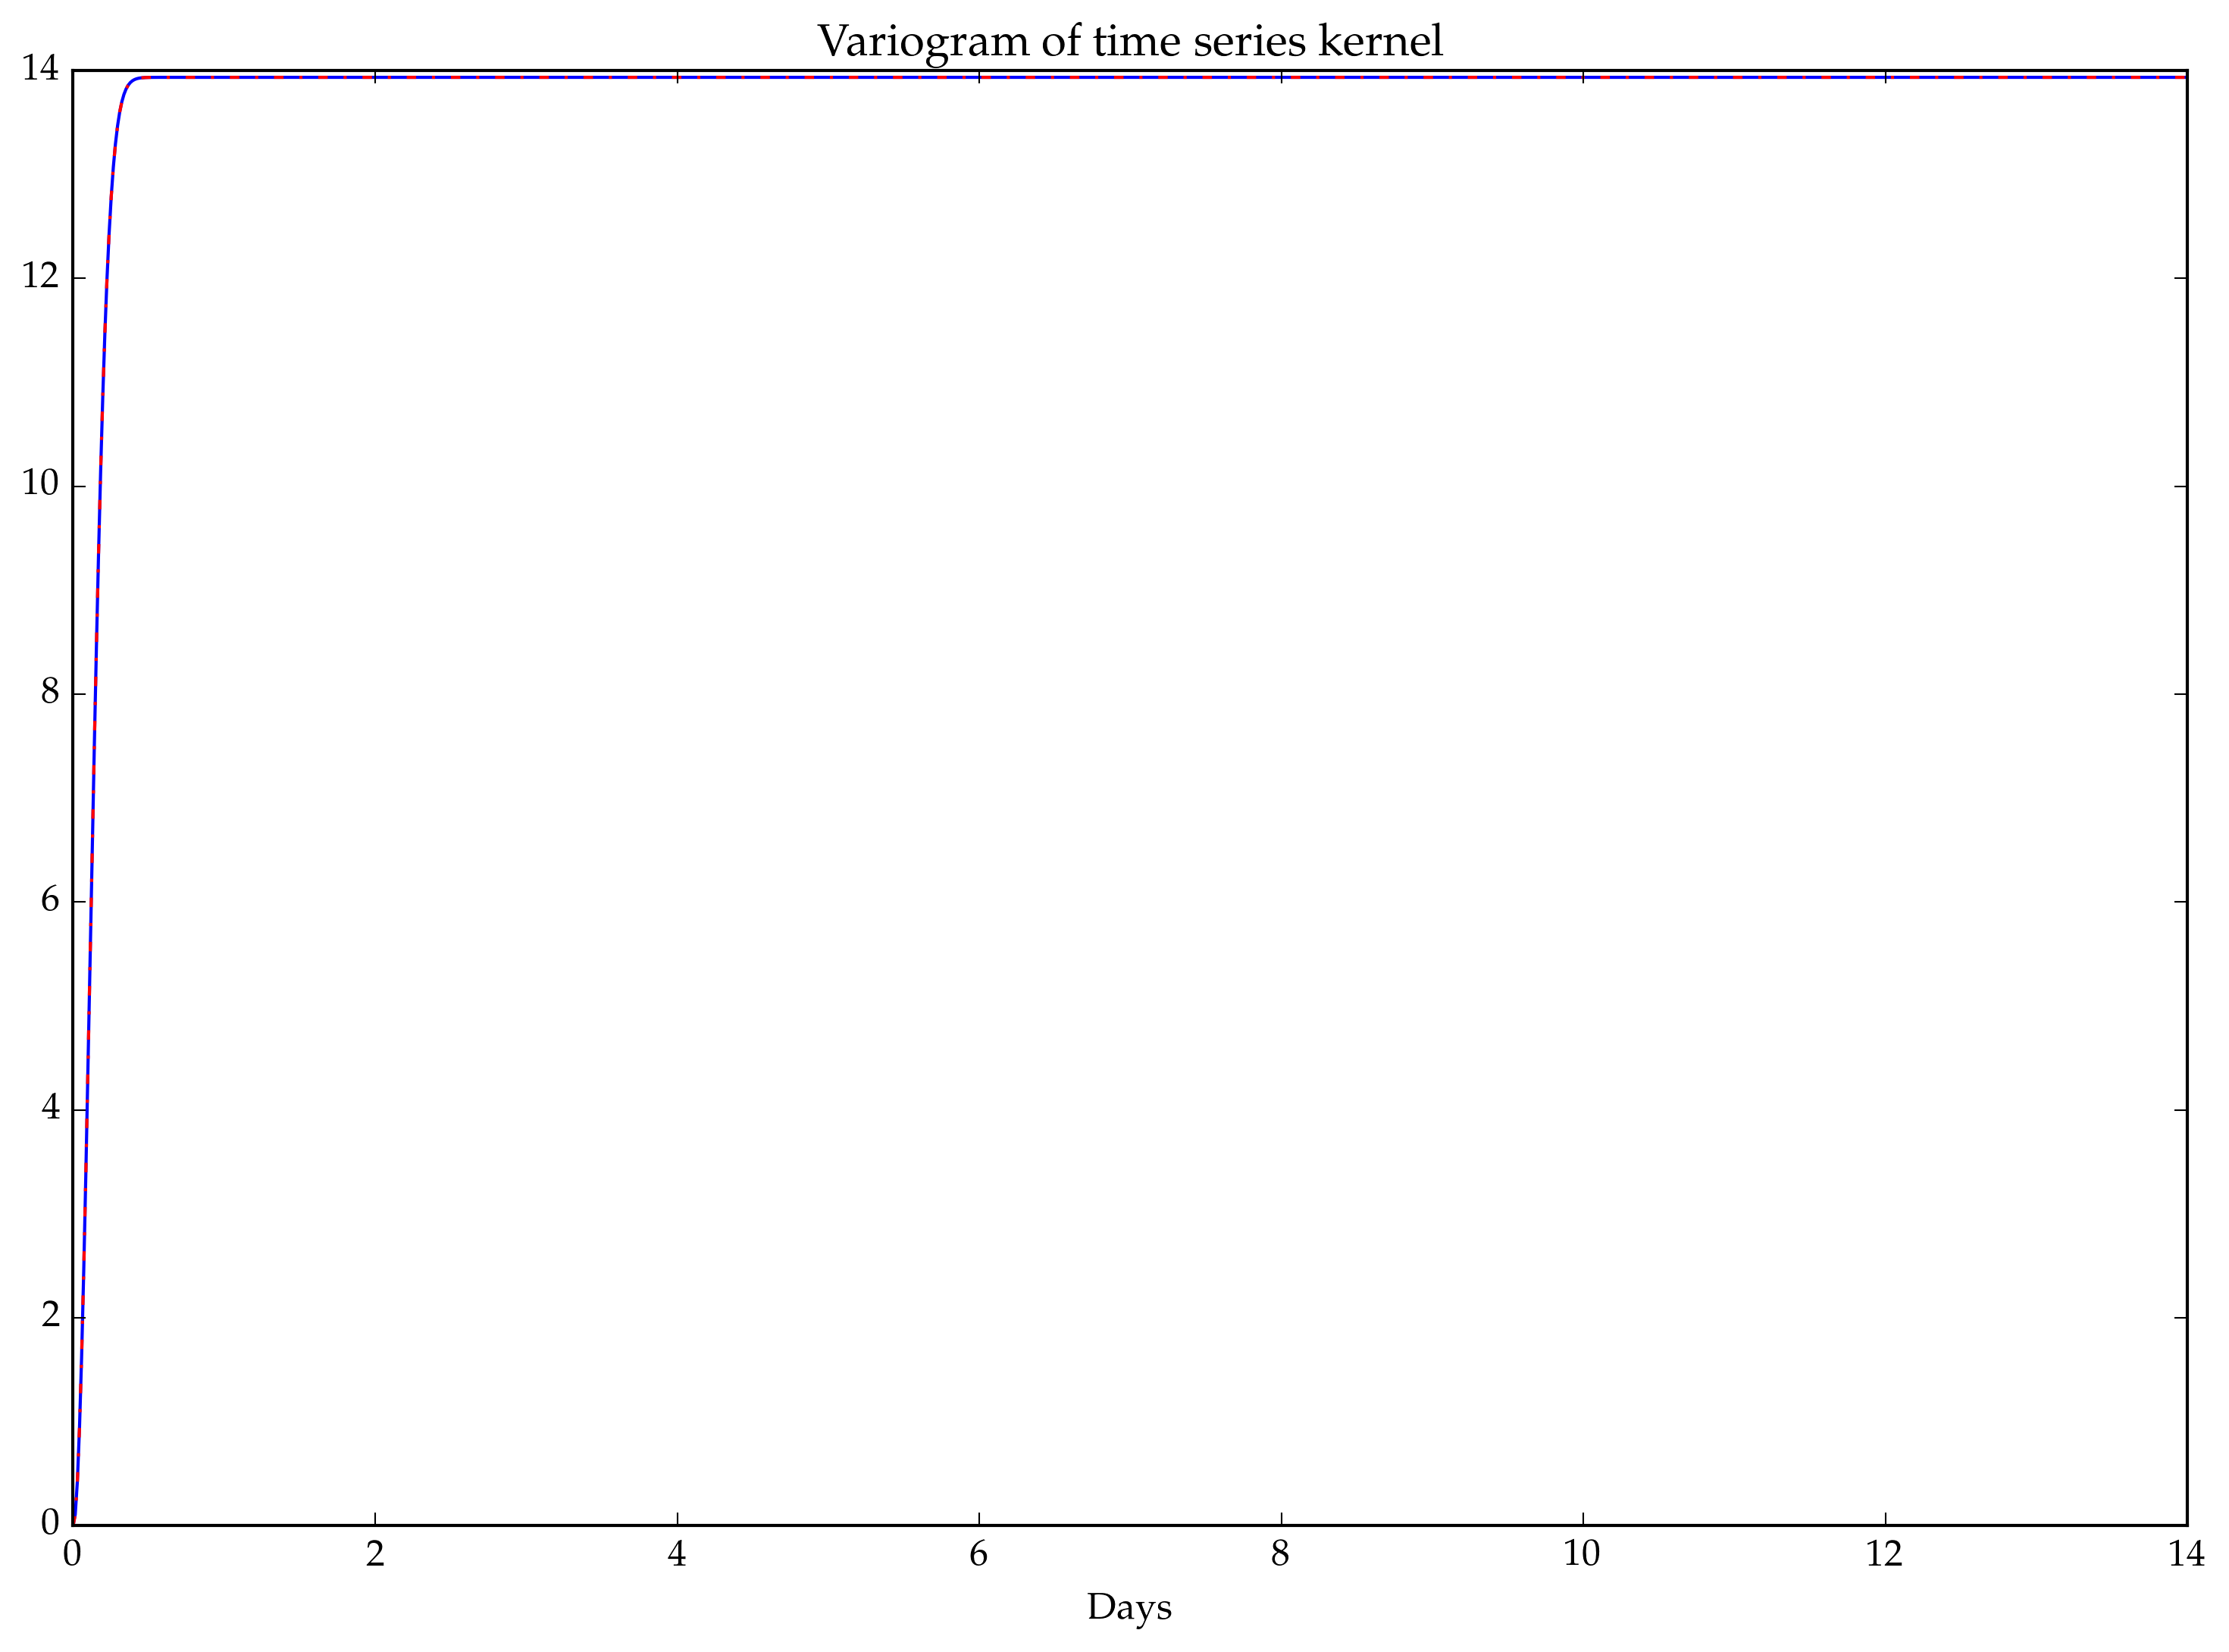

In [16]:
begin
    rr = linspace(0.0, 24*14, 1000)
    ck_r = [cov(k_time, [r], [0.0]) for r in rr]
    ck_r_2 = [cov(k_spatiotemporal, [r,0.0,0.0], [0.0,0.0,0.0]) for r in rr]
    plt.plot(rr/24, ck_r[1]-ck_r)
    plt.plot(rr/24, ck_r_2[1]-ck_r_2, linestyle="-.", color="red")
    plt.xlabel("Days")
    plt.title("Variogram of time series kernel")
end
;

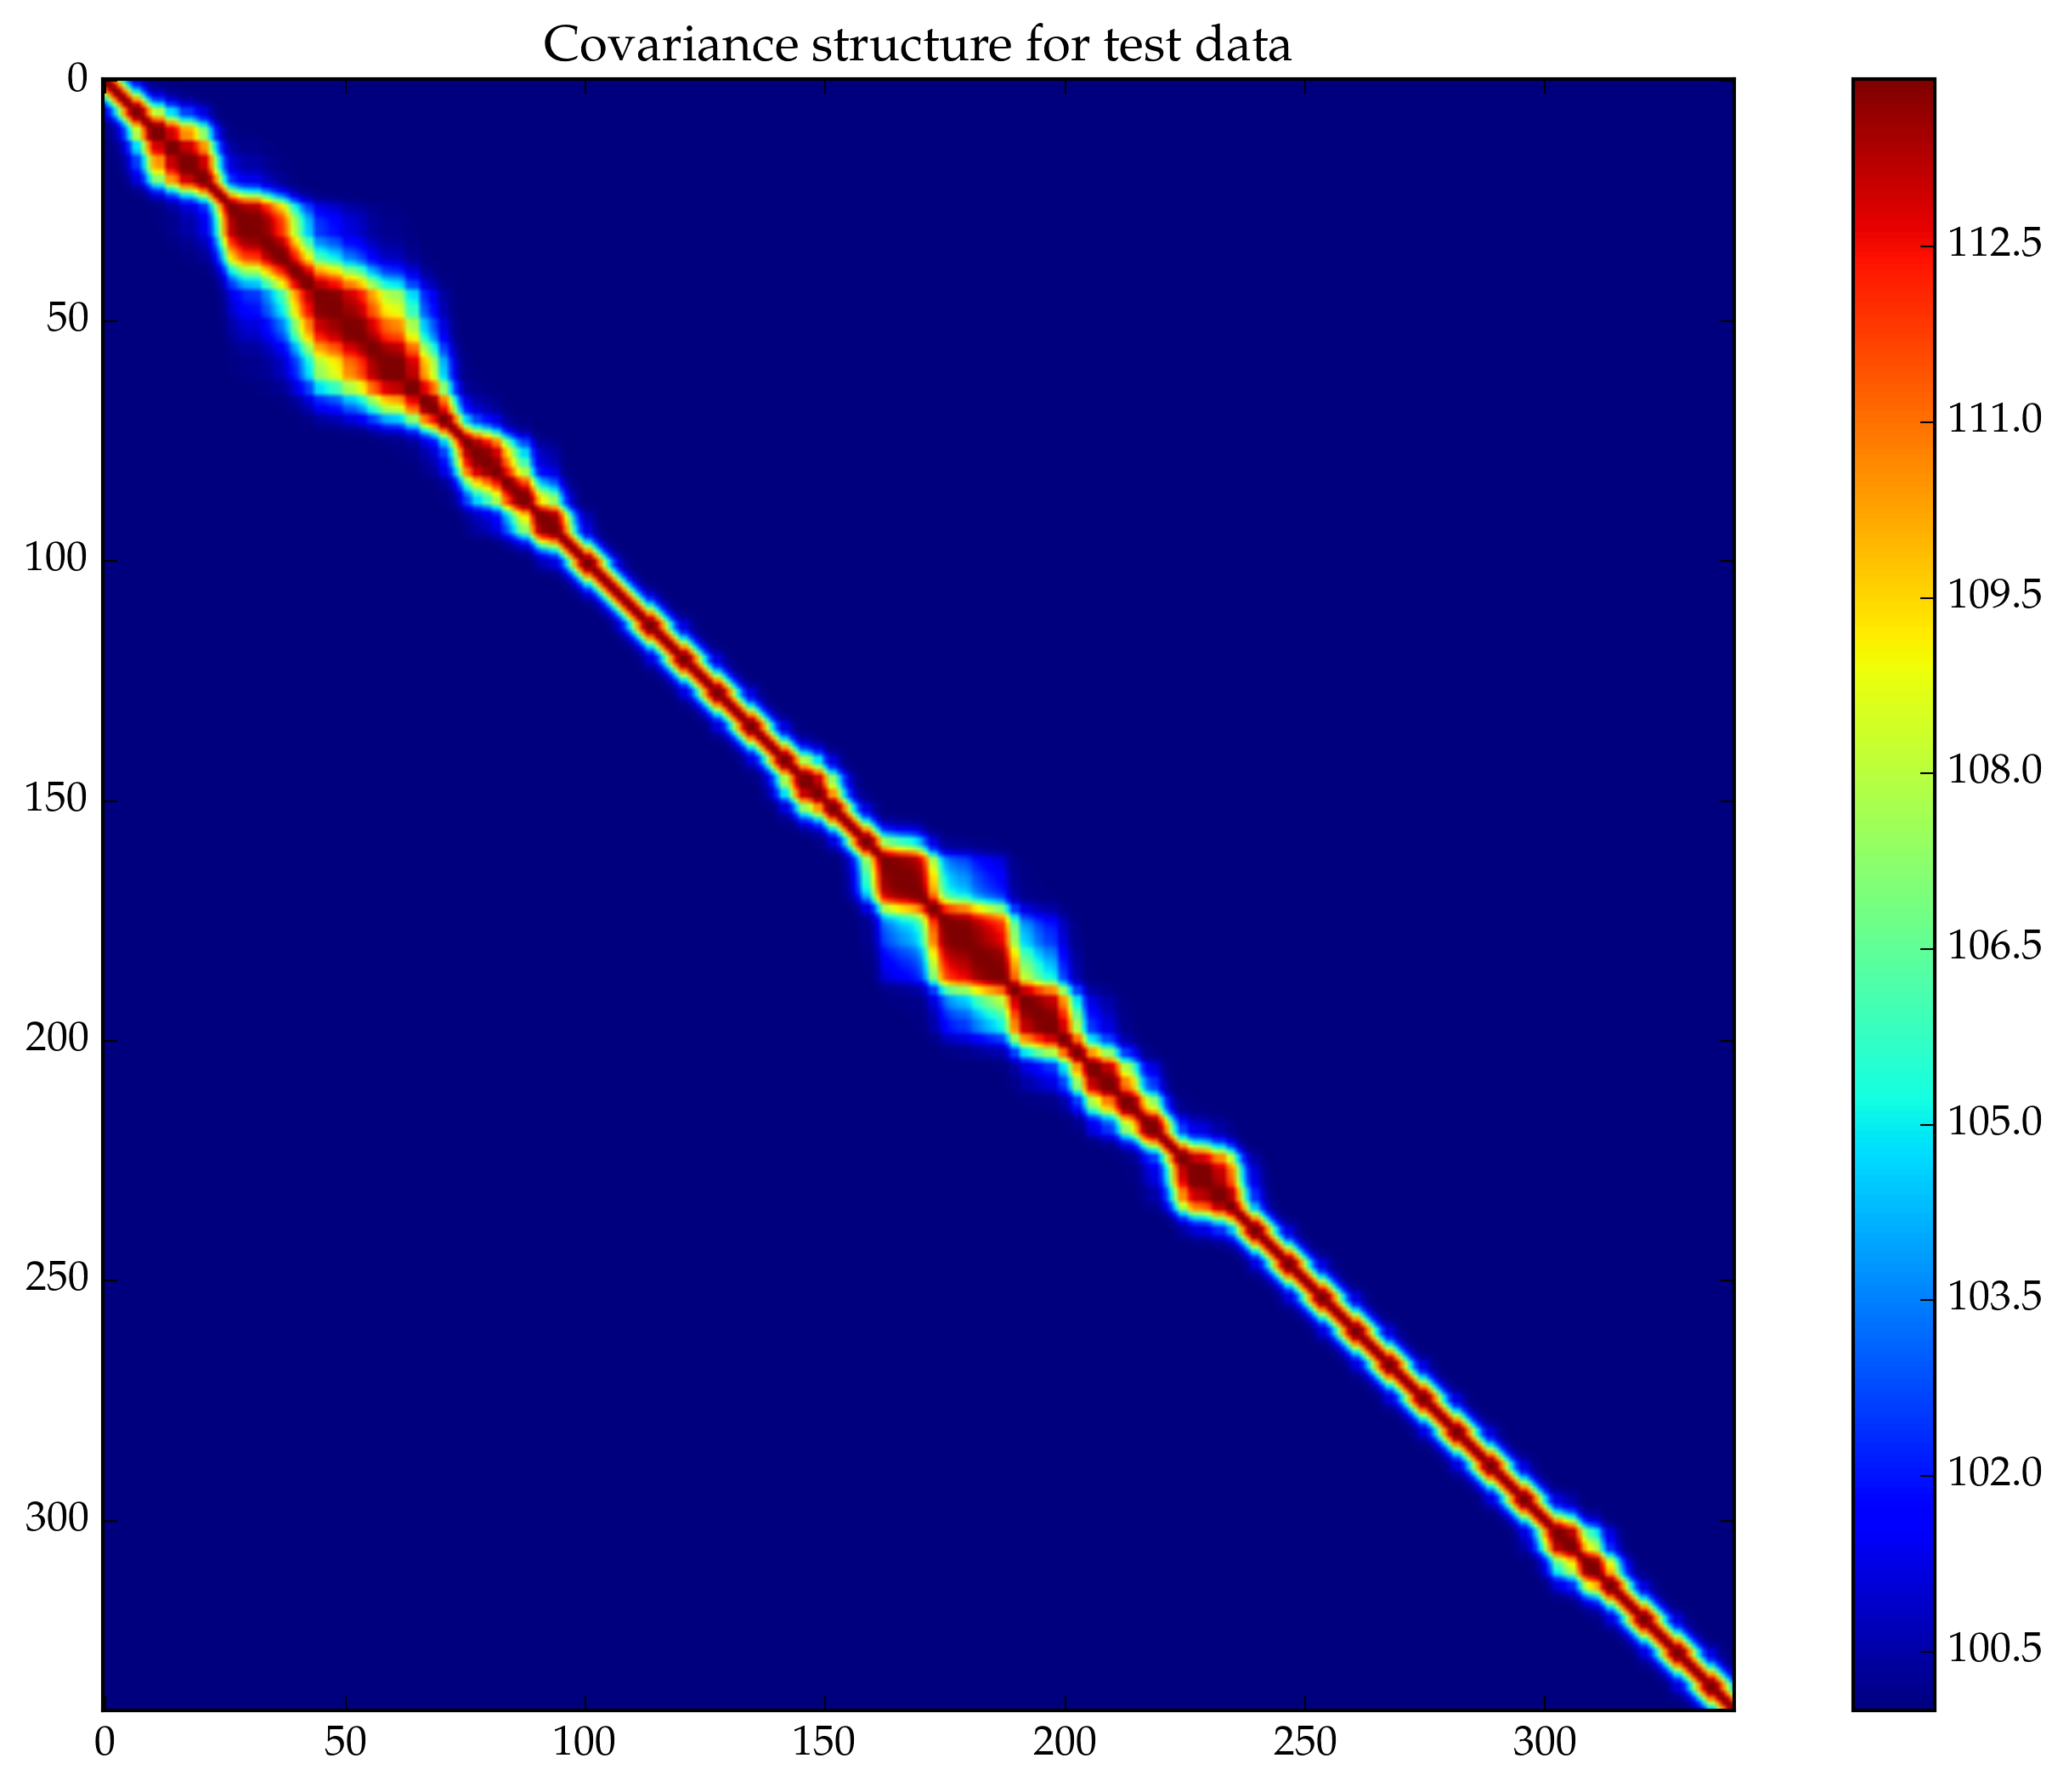

PyObject <matplotlib.colorbar.Colorbar object at 0x324e48e10>

In [17]:
plt.imshow(cov(k_spatiotemporal, test_X'))
plt.title("Covariance structure for test data")
plt.colorbar()

## Predicting at the test location

In [18]:
function add_diag!(Σ::PDMats.PDMat, a::Float64)
    mat = Σ.mat
    for i in 1:size(mat,1)
        mat[i,i] += a
    end
    copy!(Σ.chol.factors, mat)
    cholfact!(Σ.chol.factors, Symbol(Σ.chol.uplo))
    @assert sumabs(mat .- full(Σ.chol)) < 1e-8
    return Σ
end
;

  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  likely near /Users/imolk/.julia/v0.5/IJulia/src/kernel.jl:31
in show at /Users/imolk/.julia/v0.5/PyCall/src/PyCall.jl
  li

In [19]:
test_prediction=predict(train_GP, test_X'; full_cov=true)
prior_prediction=predict(prior_GP, test_X'; full_cov=true)
add_diag!(test_prediction[2], exp(2*logNoise))
add_diag!(prior_prediction[2], exp(2*logNoise))
;

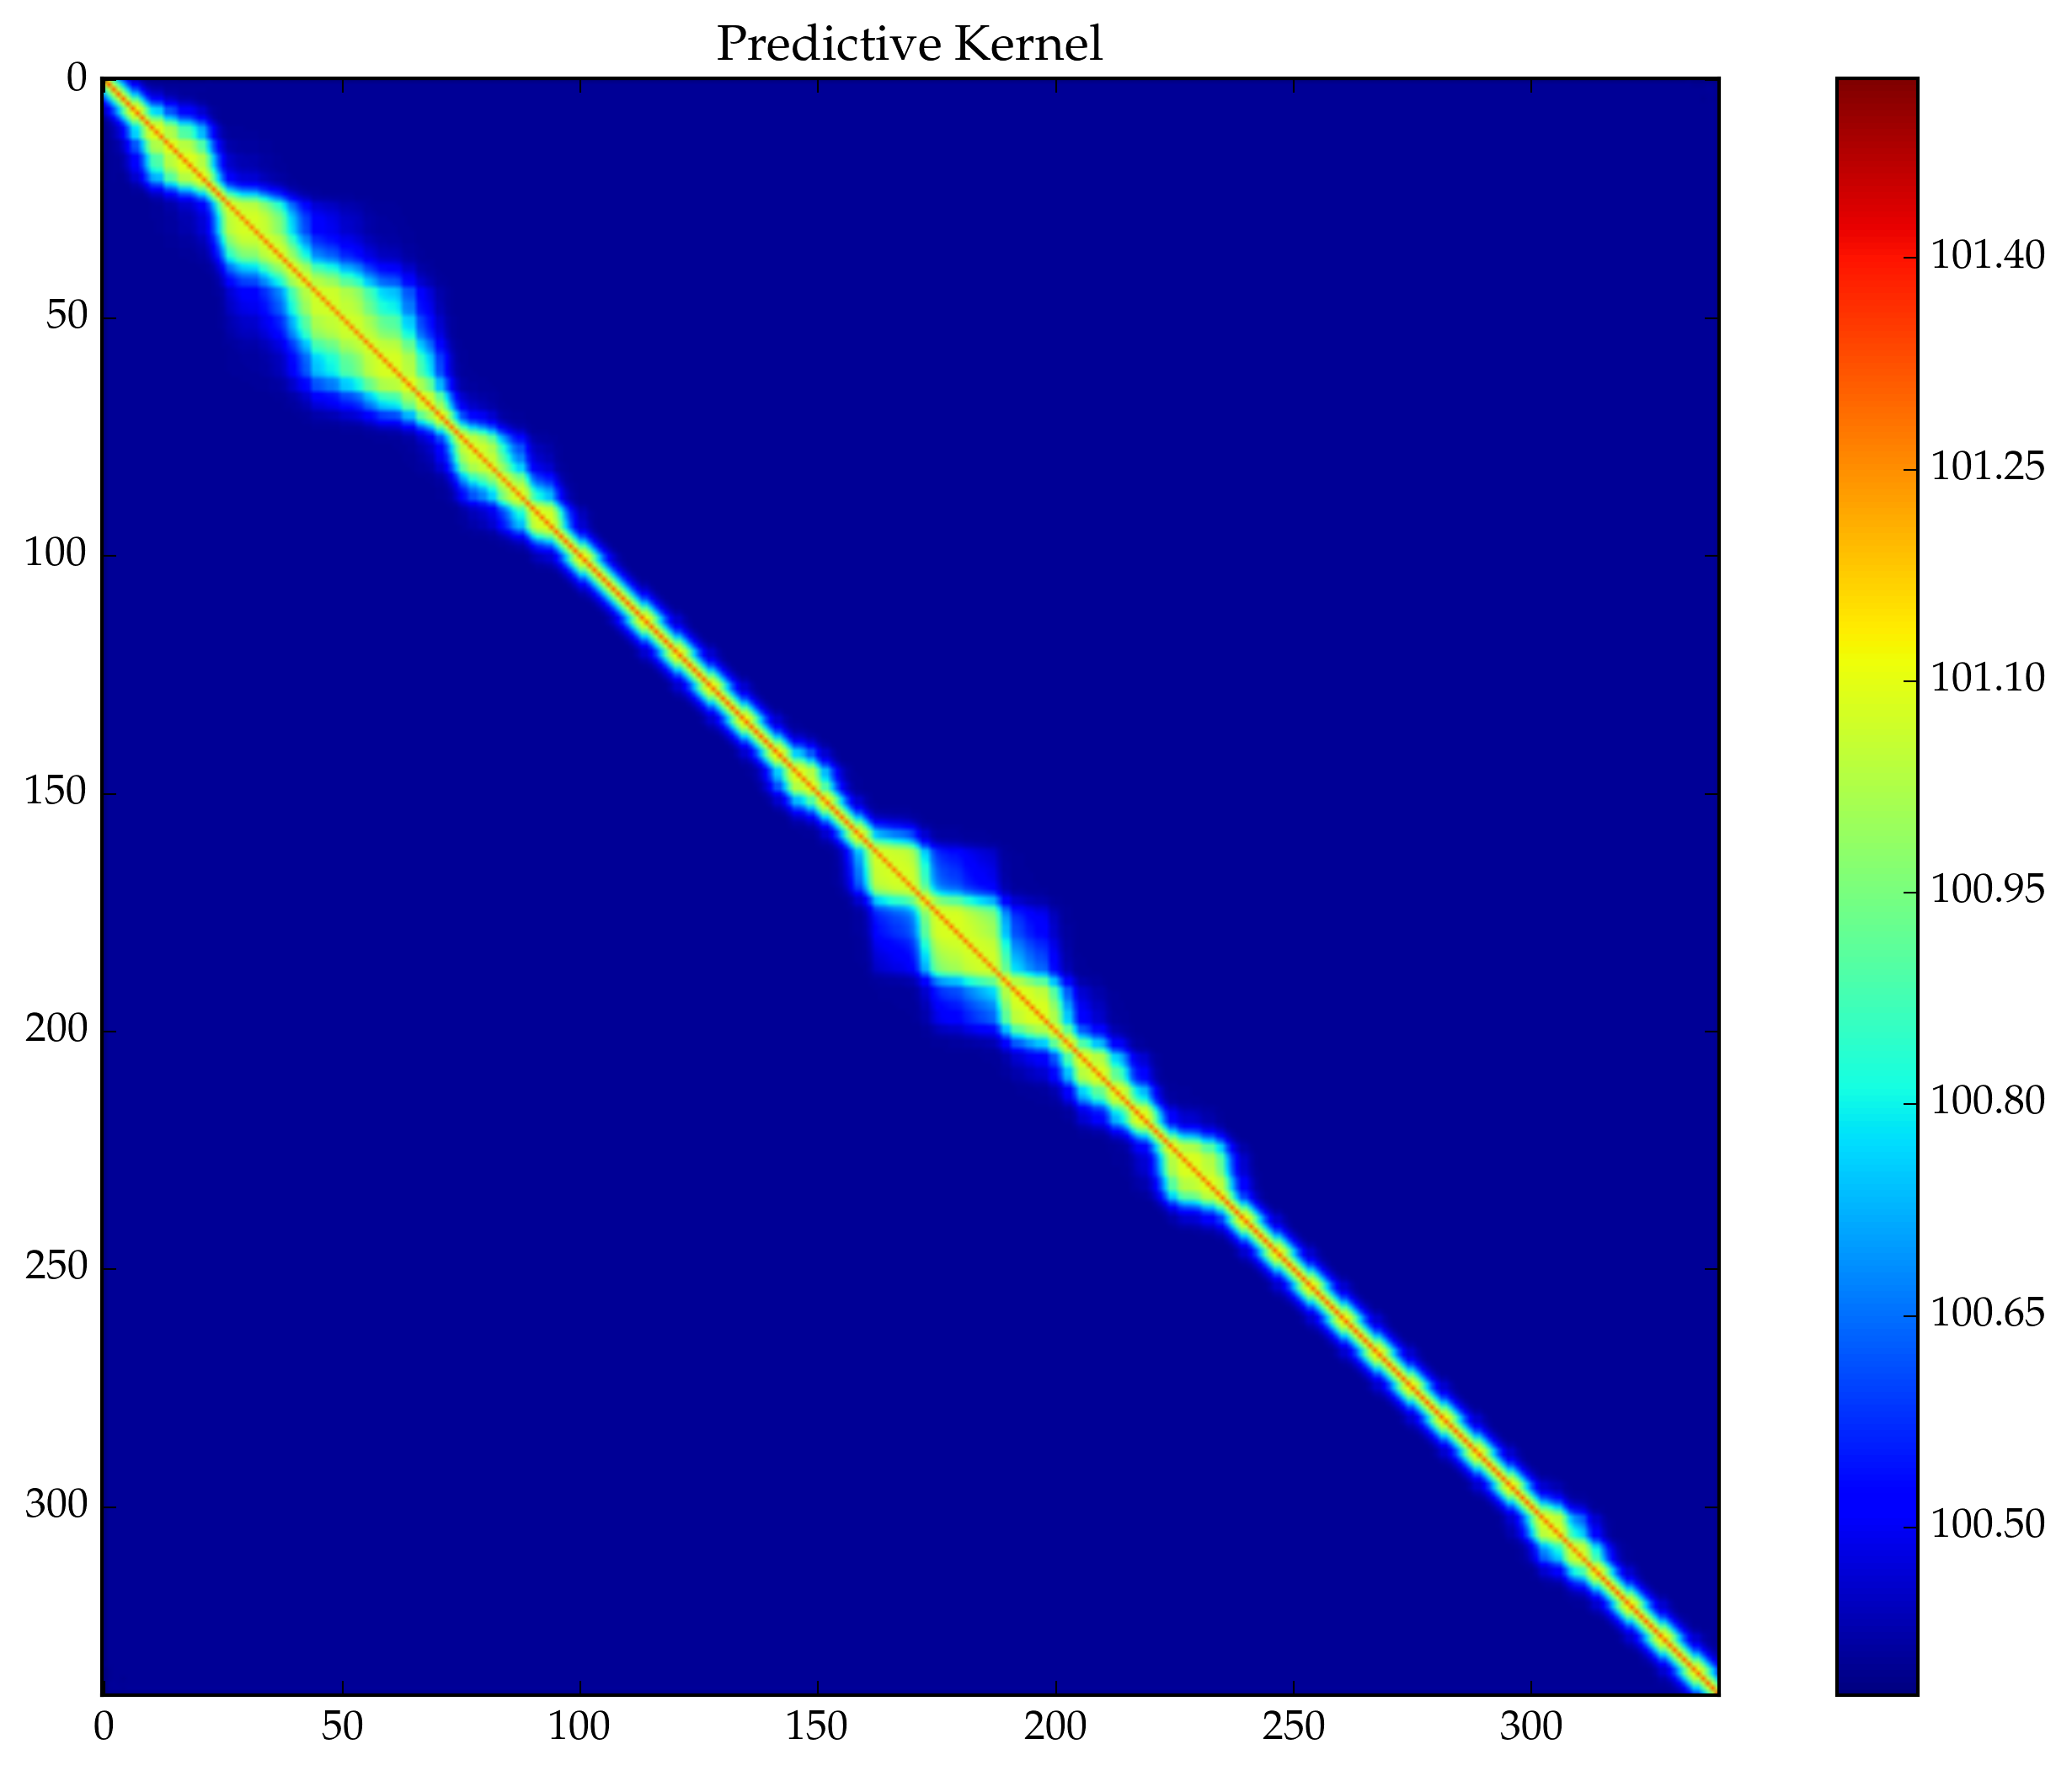

PyObject <matplotlib.colorbar.Colorbar object at 0x31b6b7a90>

In [20]:
begin
    plt.imshow(test_prediction[2].mat)
    plt.title("Predictive Kernel")
    plt.colorbar()
end

## Prior draws

Let's look at a few draws from the prior, just to check that the time series kernel is reasonable.

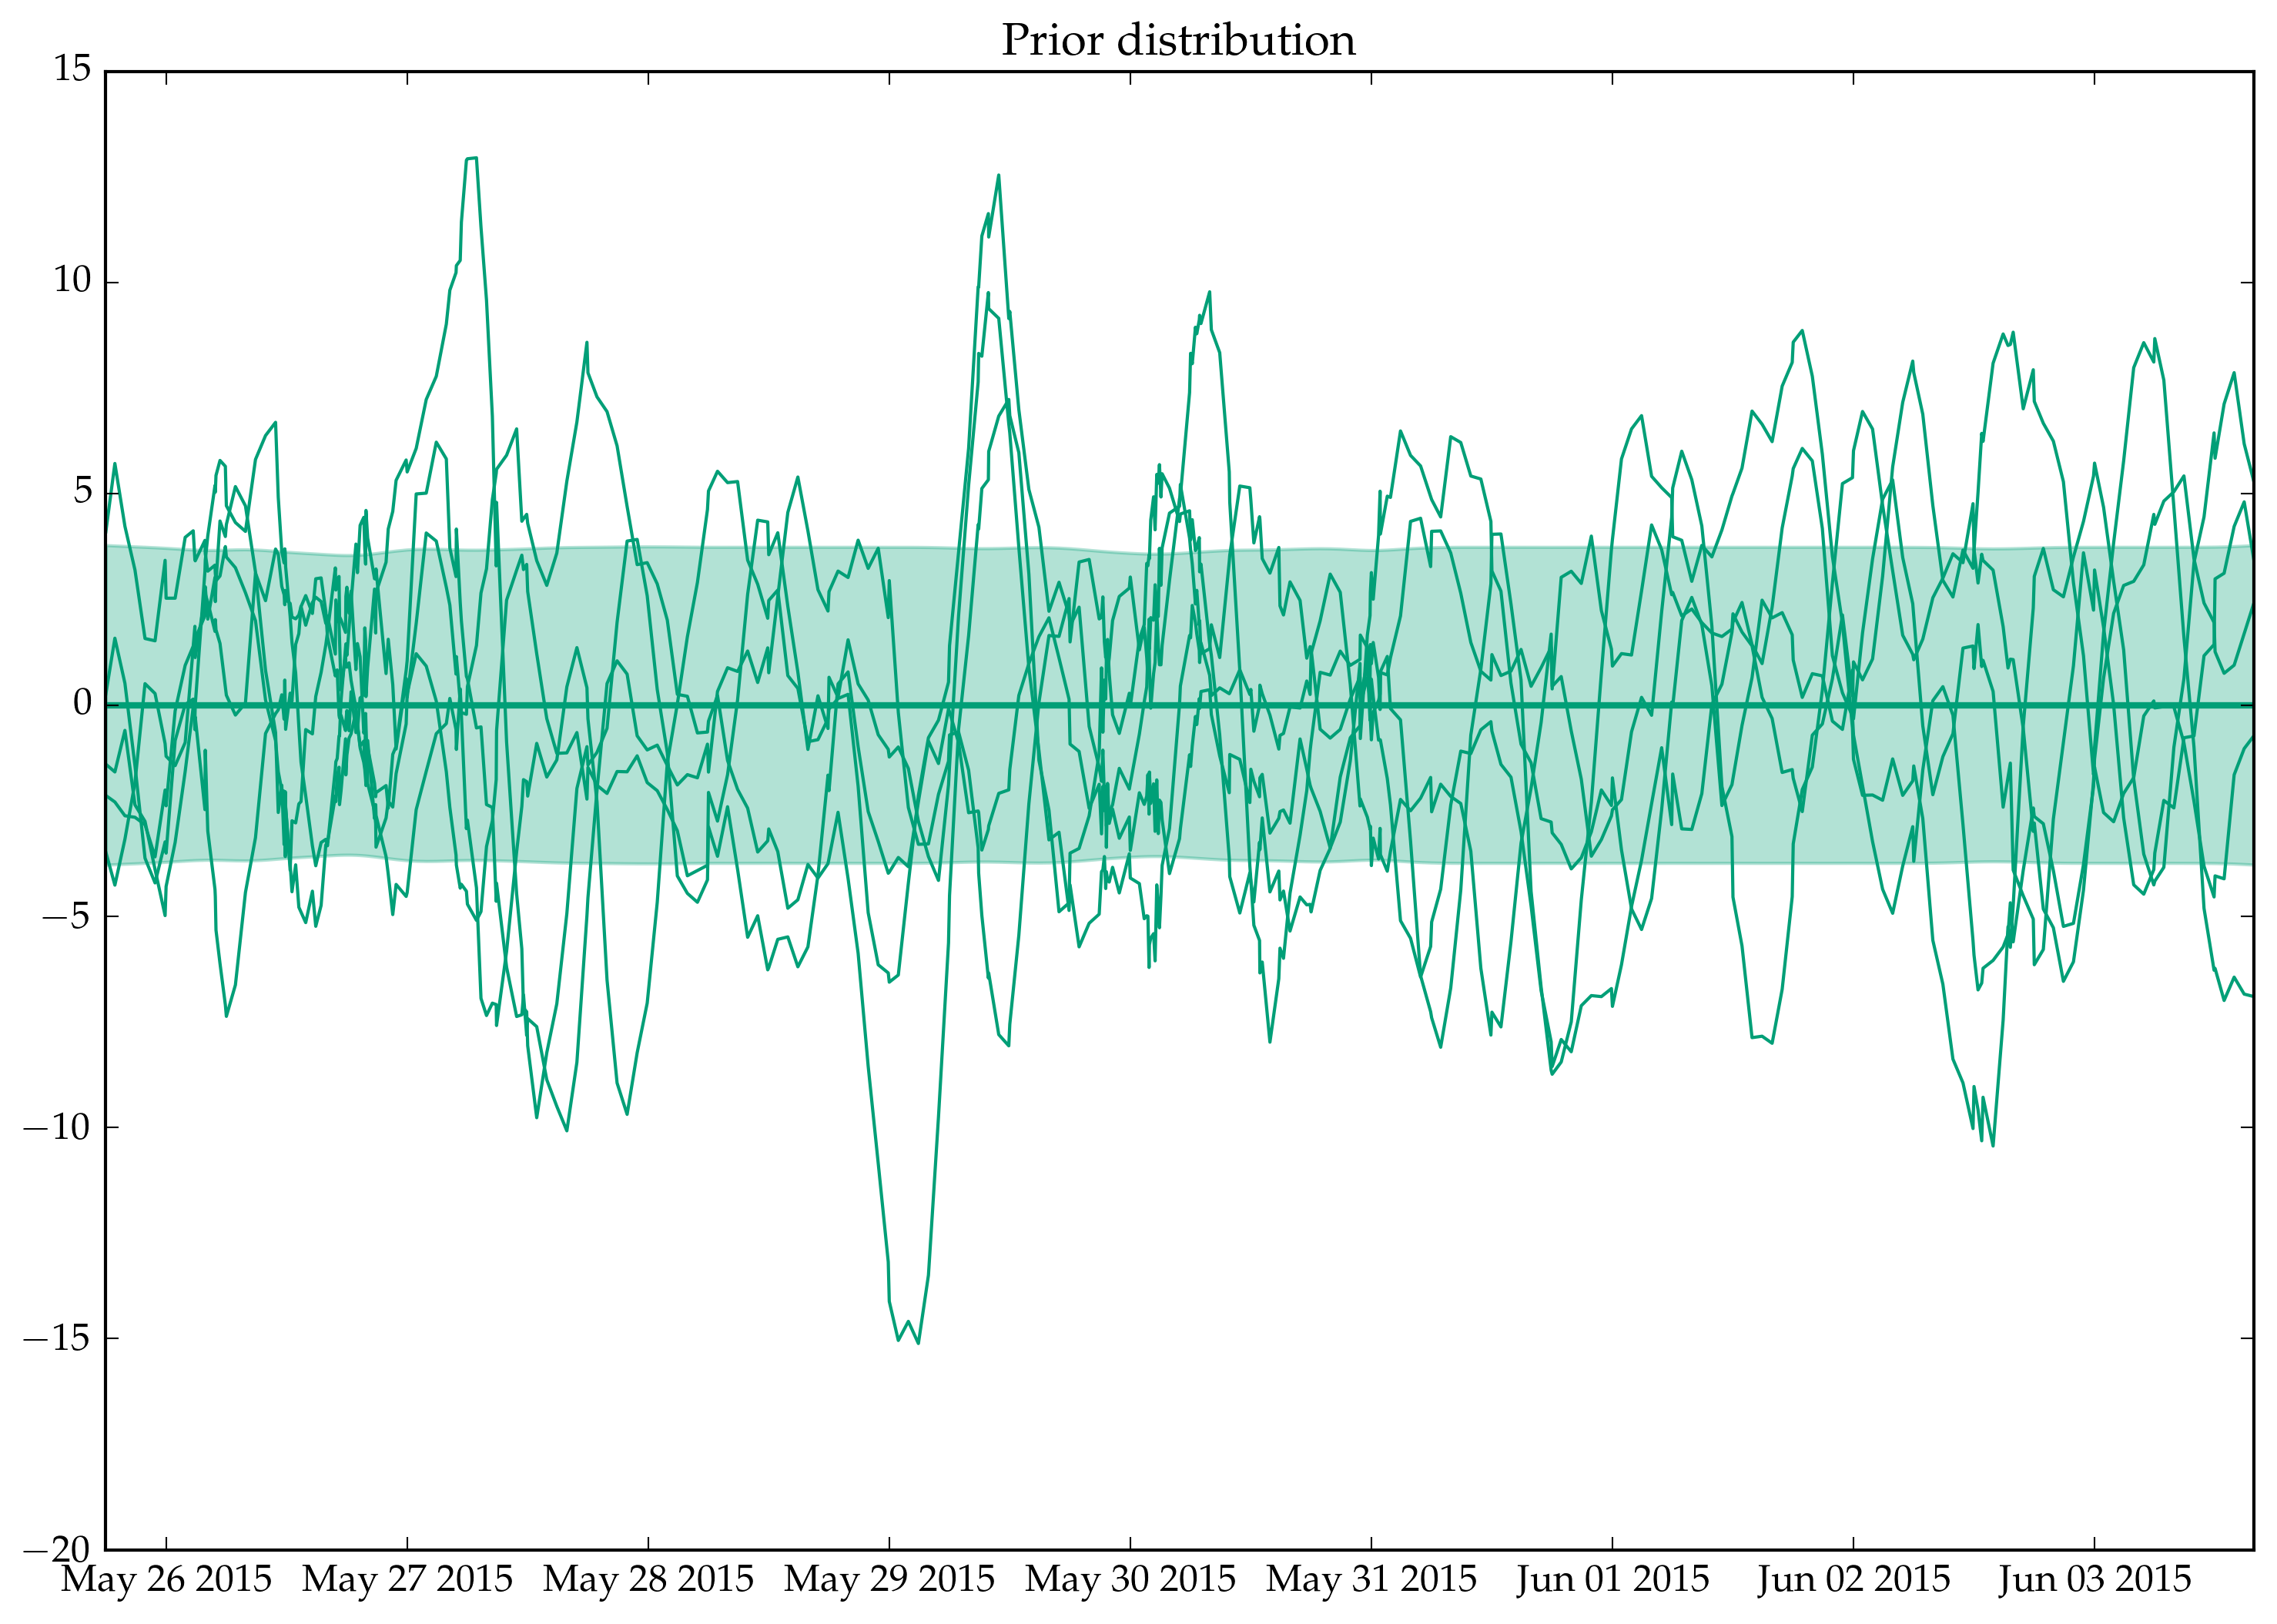

In [21]:
begin
    ts=test_subset[:ts].values
    μ = prior_prediction[1]
    Σ = prior_prediction[2]
    
    nobsv = length(μ)
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering

    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="prior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-√diag(Σ_centered),μ+√diag(Σ_centered), color="#009F77", alpha=0.3)

    plt.title("Prior distribution")
end
;

## Predictive draws

Let's show some draws from the posterior fitted using the hourly data at nearby stations, but *not* the $T_n$ and $T_x$ records.

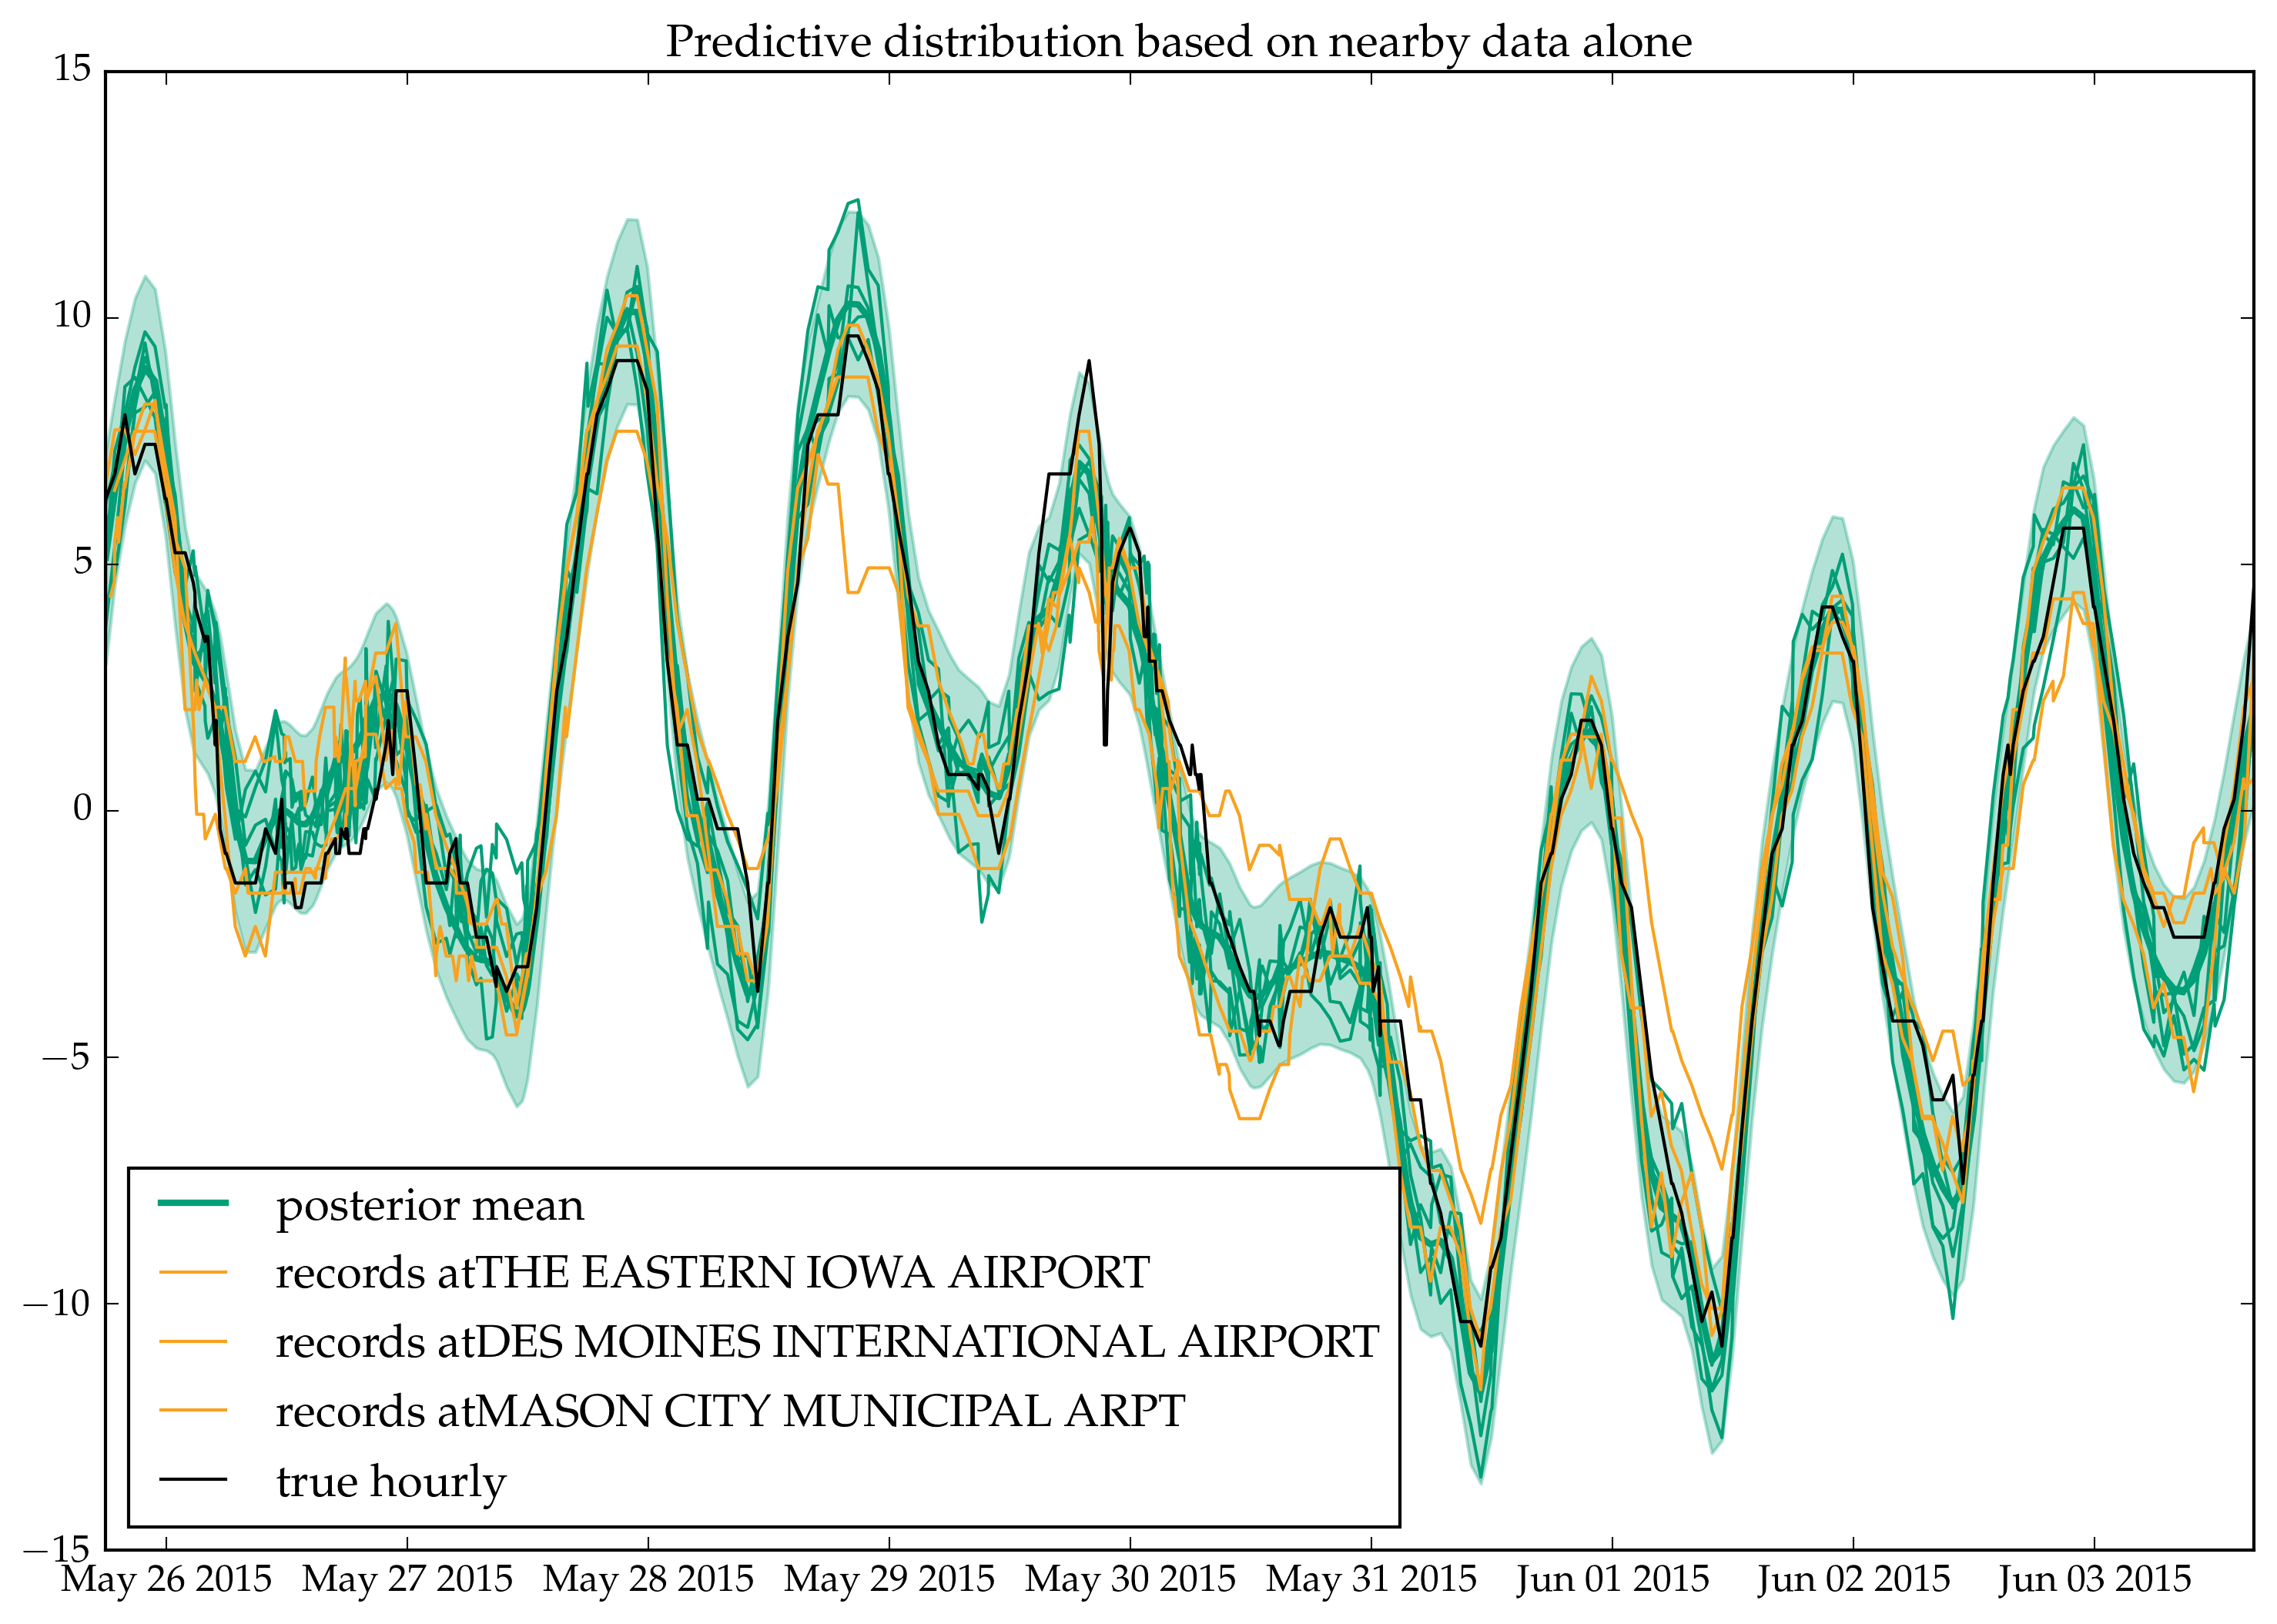

In [22]:
begin
    ts=test_subset[:ts].values
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
    plt.plot(ts, μ, color="#009F77", linewidth=2, label="posterior mean")
    for _ in 1:5
        temp_sim = rand(distr)
        plt.plot(ts, temp_sim.-mean(temp_sim), color="#009F77", linewidth=1)
    end
    plt.fill_between(ts, μ-2*√diag(Σ_centered),μ+2*√diag(Σ_centered), color="#009F77", alpha=0.3)
    for station in unique(train_subset[:station].values)
        sdata = train_subset[train_subset[:station].values.==station,:]
        ts=sdata[:ts].values
        plt.plot(ts, sdata[:temp].values.-mean(sdata[:temp].values), color="#F8A21F", 
            label="records at"get(isdSubset[station,:NAME]))
    end
    ts = test_subset[:ts].values
    temp_true = test_subset[:temp].values
    plt.plot(ts, temp_true.-mean(temp_true), 
        color="black", "-", label="true hourly")
    plt.legend(loc="best")
    plt.title("Predictive distribution based on nearby data alone")
end
;

## Diagnostic measures

In [23]:
begin
    ts=test_subset[:ts].values
    μ = test_prediction[1]
    Σ = test_prediction[2]
    nobsv = length(μ)
    
    centering = eye(nobsv) .- (1.0/nobsv) .* ones(nobsv, nobsv)
    Σ_centered = centering * Σ.mat * centering
    distr = MultivariateNormal(μ, Σ)
#     println("sum(Σ_centered)=", sum(Σ_centered*Σ_centered))
    for _ in 1:5
        temp_sim = rand(distr)
        println("var(predicted mean - simulated prediction)=", var(μ .- temp_sim))
    end
    temp_true = test_subset[:temp].values
    println("E(var(predicted mean - predictive draw))=", mean(var(μ .- rand(distr)) for _ in 1:10000))
    println("var(truth - predicted mean)=", var(μ .- temp_true))
end
;

var(predicted mean - simulated prediction)=0.7257199887946424
var(predicted mean - simulated prediction)=0.6996592004377621
var(predicted mean - simulated prediction)=0.7385228361751186
var(predicted mean - simulated prediction)=0.9630556613072697
var(predicted mean - simulated prediction)=0.6627298973503505
E(var(predicted mean - predictive draw))=0.8554476381916191
var(truth - predicted mean)=1.5647153657186834


That's actually pretty good!

# STAN imputations

## Model specification

In [22]:
reparam_model_str = """
functions {
    real softmax(vector x, real k){
        real max10x;
        max10x = max(k*x);
        return (max10x+log(sum(exp(k*x - max10x))))/k;
    }
    real softmin(vector x, real k){
        return -softmax(-x, k);
    }
}
data {
    // Tn Tx data
    int<lower=1> N_TxTn; //
    vector[N_TxTn] Tx;
    vector[N_TxTn] Tn;
    
    // imputation points (for which we have )
    int<lower=1> Nimpt;
    int<lower=1,upper=N_TxTn> day_impute[Nimpt];
    // number of hours recorded within each day
    int<lower=1> impt_times_p_day[N_TxTn];
    
    // prior 
    vector[Nimpt] predicted_mean;
    matrix[Nimpt,Nimpt] predicted_cov;
    matrix[Nimpt,Nimpt] predicted_cov_chol;
    
    // control soft max hardness
    real<lower=0> k_softmax;
}
parameters {
    vector[Nimpt] w_uncorr;
    real mu;
}
transformed parameters {
    vector[Nimpt] temp_impt;
    real Tsoftmax[N_TxTn];
    real Tsoftmin[N_TxTn];  
    temp_impt = mu + predicted_mean + predicted_cov_chol*w_uncorr;
    {
        int istart;
        istart = 1;
        for (i in 1:N_TxTn){
            int ntimes;
            ntimes = impt_times_p_day[i];
            Tsoftmin[i] = softmin(segment(temp_impt,istart,ntimes), k_softmax);
            Tsoftmax[i] = softmax(segment(temp_impt,istart,ntimes), k_softmax);
            istart = istart + ntimes;
        }
    }
}
model {
    w_uncorr ~ normal(0,1);
    mu ~ normal(0, 100.0);
    Tn ~ normal(Tsoftmin, 0.1);
    Tx ~ normal(Tsoftmax, 0.1);
}
"""
;

## preparing Stan data

In [24]:
test_TxTn = by(test_subset, :ts_day, df -> DataFrame(
    Tn=first(df[:Tn]), 
    Tx=first(df[:Tx]), 
    times_p_day=nrow(df),
))

9×4 DataFrames.DataFrame
│ Row │ ts_day     │ Tn   │ Tx   │ times_p_day │
├─────┼────────────┼──────┼──────┼─────────────┤
│ 1   │ 2015-05-26 │ 15.6 │ 25.6 │ 46          │
│ 2   │ 2015-05-27 │ 13.9 │ 22.8 │ 54          │
│ 3   │ 2015-05-28 │ 13.9 │ 26.7 │ 27          │
│ 4   │ 2015-05-29 │ 16.7 │ 27.2 │ 31          │
│ 5   │ 2015-05-30 │ 12.8 │ 26.7 │ 59          │
│ 6   │ 2015-05-31 │ 6.7  │ 16.1 │ 36          │
│ 7   │ 2015-06-01 │ 6.7  │ 19.4 │ 28          │
│ 8   │ 2015-06-02 │ 10.0 │ 21.7 │ 32          │
│ 9   │ 2015-06-03 │ 15.0 │ 23.9 │ 27          │

In [25]:
ts_day = test_subset[:ts_day].values
day_impute = convert(Vector{Int}, ts_day .- minimum(ts_day))+1
imputation_data = Dict(
    "N_TxTn" => nrow(test_TxTn),
    "Tn" => test_TxTn[:Tn].values,
    "Tx" => test_TxTn[:Tx].values,
    "Nimpt" => nrow(test_subset),
    "day_impute" => day_impute,
    "impt_times_p_day" => test_TxTn[:times_p_day].values,
    "predicted_mean" => test_prediction[1],
    "predicted_cov" => test_prediction[2].mat,
    "predicted_cov_chol" => full(test_prediction[2].chol[:L]),
    "k_softmax" => 10.0,
    
)

Dict{String,Any} with 10 entries:
  "Tx"                 => [25.6,22.8,26.7,27.2,26.7,16.1,19.4,21.7,23.9]
  "predicted_cov_chol" => [10.0761 0.0 … 0.0 0.0; 10.032 0.809428 … 0.0 0.0; … …
  "impt_times_p_day"   => [46,54,27,31,59,36,28,32,27]
  "Nimpt"              => 340
  "Tn"                 => [15.6,13.9,13.9,16.7,12.8,6.7,6.7,10.0,15.0]
  "N_TxTn"             => 9
  "day_impute"         => [1,1,1,1,1,1,1,1,1,1  …  9,9,9,9,9,9,9,9,9,9]
  "predicted_cov"      => [101.528 101.084 … 100.388 100.381; 101.084 101.297 ……
  "predicted_mean"     => [5.13124,6.48653,7.66563,8.52217,8.97763,8.71283,7.48…
  "k_softmax"          => 10.0

In [28]:
nchains=4
reparam_model = Stanmodel(name="reparam", model=reparam_model_str, 
    nchains=nchains, 
    adapt=1000, 
    update=1000)

LoadError: UndefVarError: reparam_model_str not defined

## Running MCMC

In [26]:
@time sim2 = stan(reparam_model, [imputation_data], CmdStanDir=Stan.CMDSTAN_HOME, summary=false);


make: `/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/reparam' is up to date.

Length of data array is not equal to nchains,
all chains will use the first data dictionary.
1857.926261 seconds (7.50 M allocations: 536.067 MB, 0.03% gc time)


In [37]:
# convenience function to extract the imputed temperatures
# from the STAN model object
temp_varnames=[@sprintf("temp_impt.%d", i) for i in 1:imputation_data["Nimpt"]]

function get_temperatures_reparam(sim::Mamba.Chains)
    temp_samples=getindex(sim, :, temp_varnames, :).value
    return temp_samples
end

get_temperatures_reparam (generic function with 1 method)

## Plotting imputations

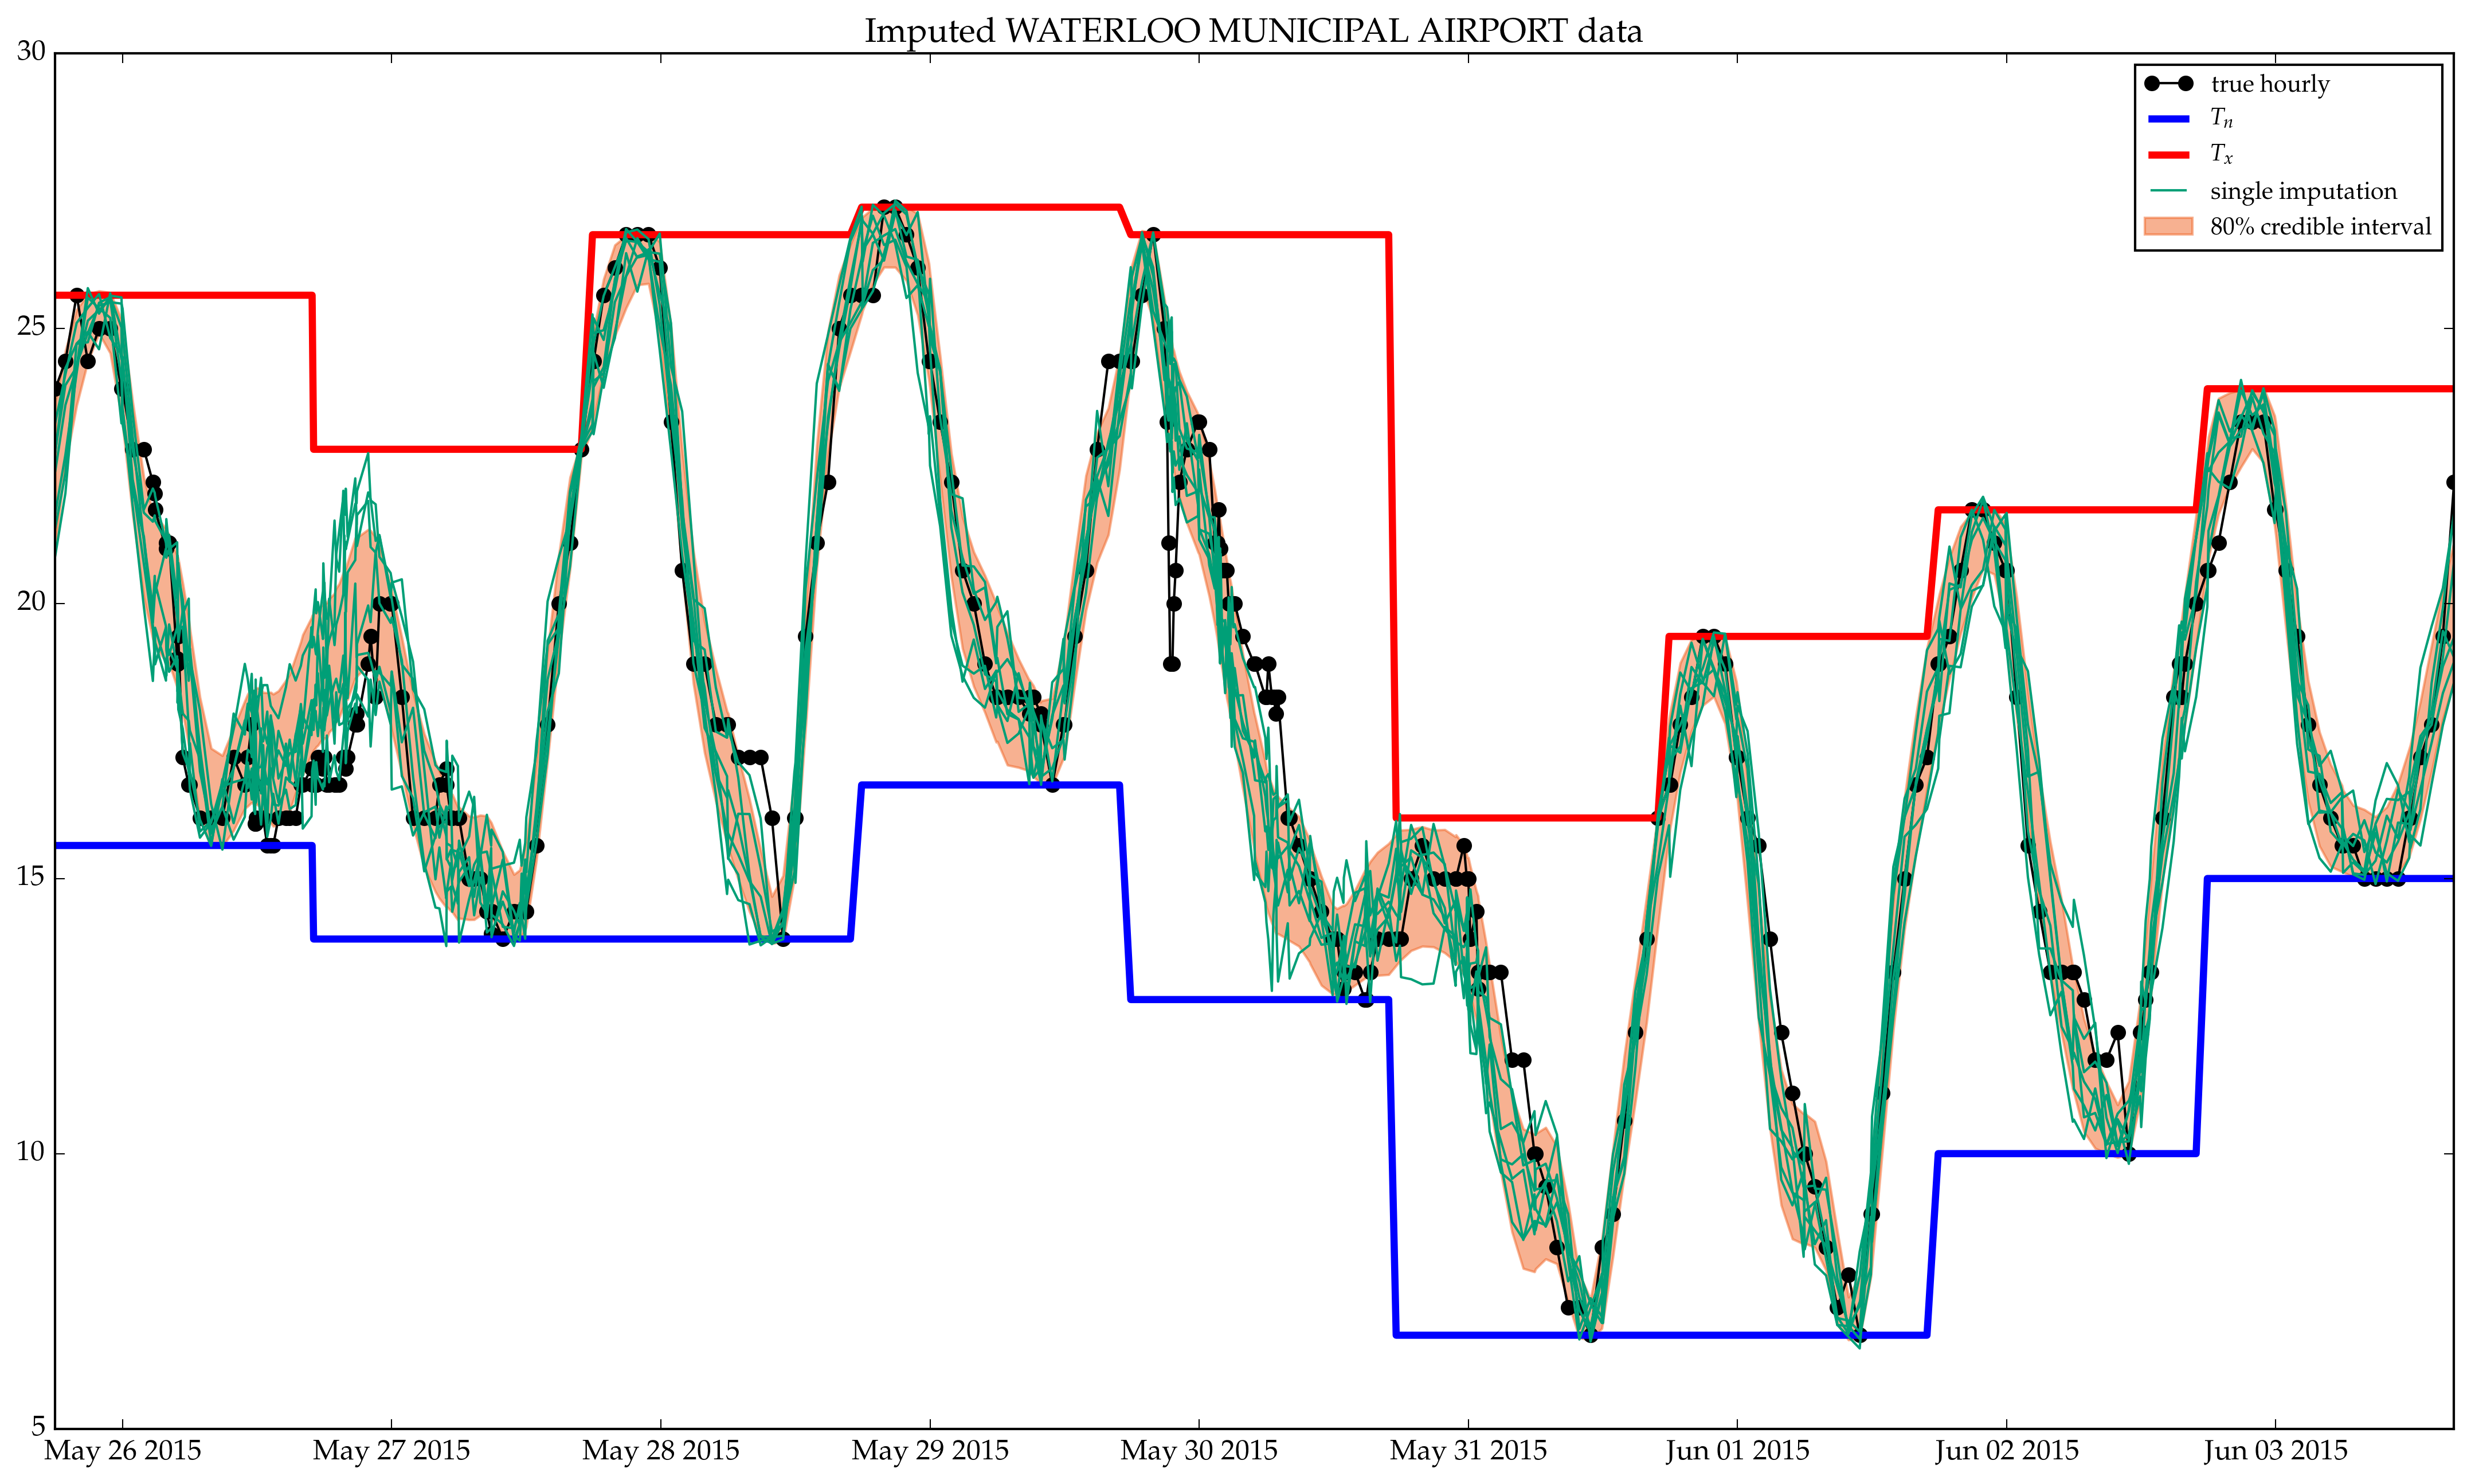

In [28]:
begin;
    temp_impute = get_temperatures_reparam(sim2)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract and 10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    ts = test_subset[:ts].values
    plt.plot(ts, test_subset[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[750,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
end;

## Changed softmax definition

In [34]:
smoothmax_str = """
functions {
    real smoothmax(vector x, real k){
        return sum(x .* exp(k*x)) / sum(exp(k*x));
    }
    real smoothmin(vector x, real k){
        return -smoothmax(-x, k);
    }
}
data {
    // Tn Tx data
    int<lower=1> N_TxTn; //
    vector[N_TxTn] Tx;
    vector[N_TxTn] Tn;
    
    // imputation points (for which we have )
    int<lower=1> Nimpt;
    int<lower=1,upper=N_TxTn> day_impute[Nimpt];
    // number of hours recorded within each day
    int<lower=1> impt_times_p_day[N_TxTn];
    
    // prior 
    vector[Nimpt] predicted_mean;
    matrix[Nimpt,Nimpt] predicted_cov;
    matrix[Nimpt,Nimpt] predicted_cov_chol;
    
    // control soft max hardness
    real<lower=0> k_softmax;
}
parameters {
    vector[Nimpt] w_uncorr;
    real mu;
}
transformed parameters {
    vector[Nimpt] temp_impt;
    real Tsoftmax[N_TxTn];
    real Tsoftmin[N_TxTn];  
    temp_impt = mu + predicted_mean + predicted_cov_chol*w_uncorr;
    {
        int istart;
        istart = 1;
        for (i in 1:N_TxTn){
            int ntimes;
            ntimes = impt_times_p_day[i];
            Tsoftmin[i] = smoothmin(segment(temp_impt,istart,ntimes), k_softmax);
            Tsoftmax[i] = smoothmax(segment(temp_impt,istart,ntimes), k_softmax);
            istart = istart + ntimes;
        }
    }
}
model {
    w_uncorr ~ normal(0,1);
    mu ~ normal(0, 100.0);
    Tn ~ normal(Tsoftmin, 0.1);
    Tx ~ normal(Tsoftmax, 0.1);
}
"""
;

In [35]:
smoothmax_model = Stanmodel(name="smoothmax", model=smoothmax_str, 
    nchains=nchains, 
    adapt=1000, 
    update=1000)


File /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax.stan will be updated.



  name =                    "smoothmax"
  nchains =                 4
  update =                   1000
  adapt =                    1000
  thin =                     1
  monitors =                String[]
  model_file =              "smoothmax.stan"
  data_file =                ""
  output =                  Output()
    file =                    ""
    diagnostics_file =        ""
    refresh =                 100
  method =                  Sample()
    num_samples =             1000
    num_warmup =              1000
    save_warmup =             false
    thin =                    1
    algorithm =               HMC()
      engine =                  NUTS()
        max_depth =               10
      metric =                  Stan.diag_e
      stepsize =                1.0
      stepsize_jitter =         1.0
    adapt =                   Adapt()
      gamma =                   0.05
      delta =                   0.8
      kappa =                   0.75
      t0 =                   

In [36]:
@time sim3 = stan(smoothmax_model, [imputation_data], CmdStanDir=Stan.CMDSTAN_HOME, summary=false);



--- Translating Stan model to C++ code ---
bin/stanc /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax.stan --o=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax.hpp
Model name=smoothmax_model
Input file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax.stan
Output file=/Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax.hpp

--- Linking C++ model ---
g++ -I src -I stan_2.12.0/src -isystem stan_2.12.0/lib/stan_math_2.12.0/ -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/eigen_3.2.9 -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/boost_1.60.0 -isystem stan_2.12.0/lib/stan_math_2.12.0/lib/cvodes_2.8.2/include -Wall -DEIGEN_NO_DEBUG  -DBOOST_RESULT_OF_USE_TR1 -DBOOST_NO_DECLTYPE -DBOOST_DISABLE_ASSERTS -DFUSION_MAX_VECTOR_SIZE=12 -DNO_FPRINTF_OUTPUT -pipe  -Wno-unused-function -ftemplate-depth-256    -O3 -o /Users/imolk/Documents/Harvard/Natesh/temperature_model/tmp/smoothmax src/cmdstan/main.cpp -include /Users/i

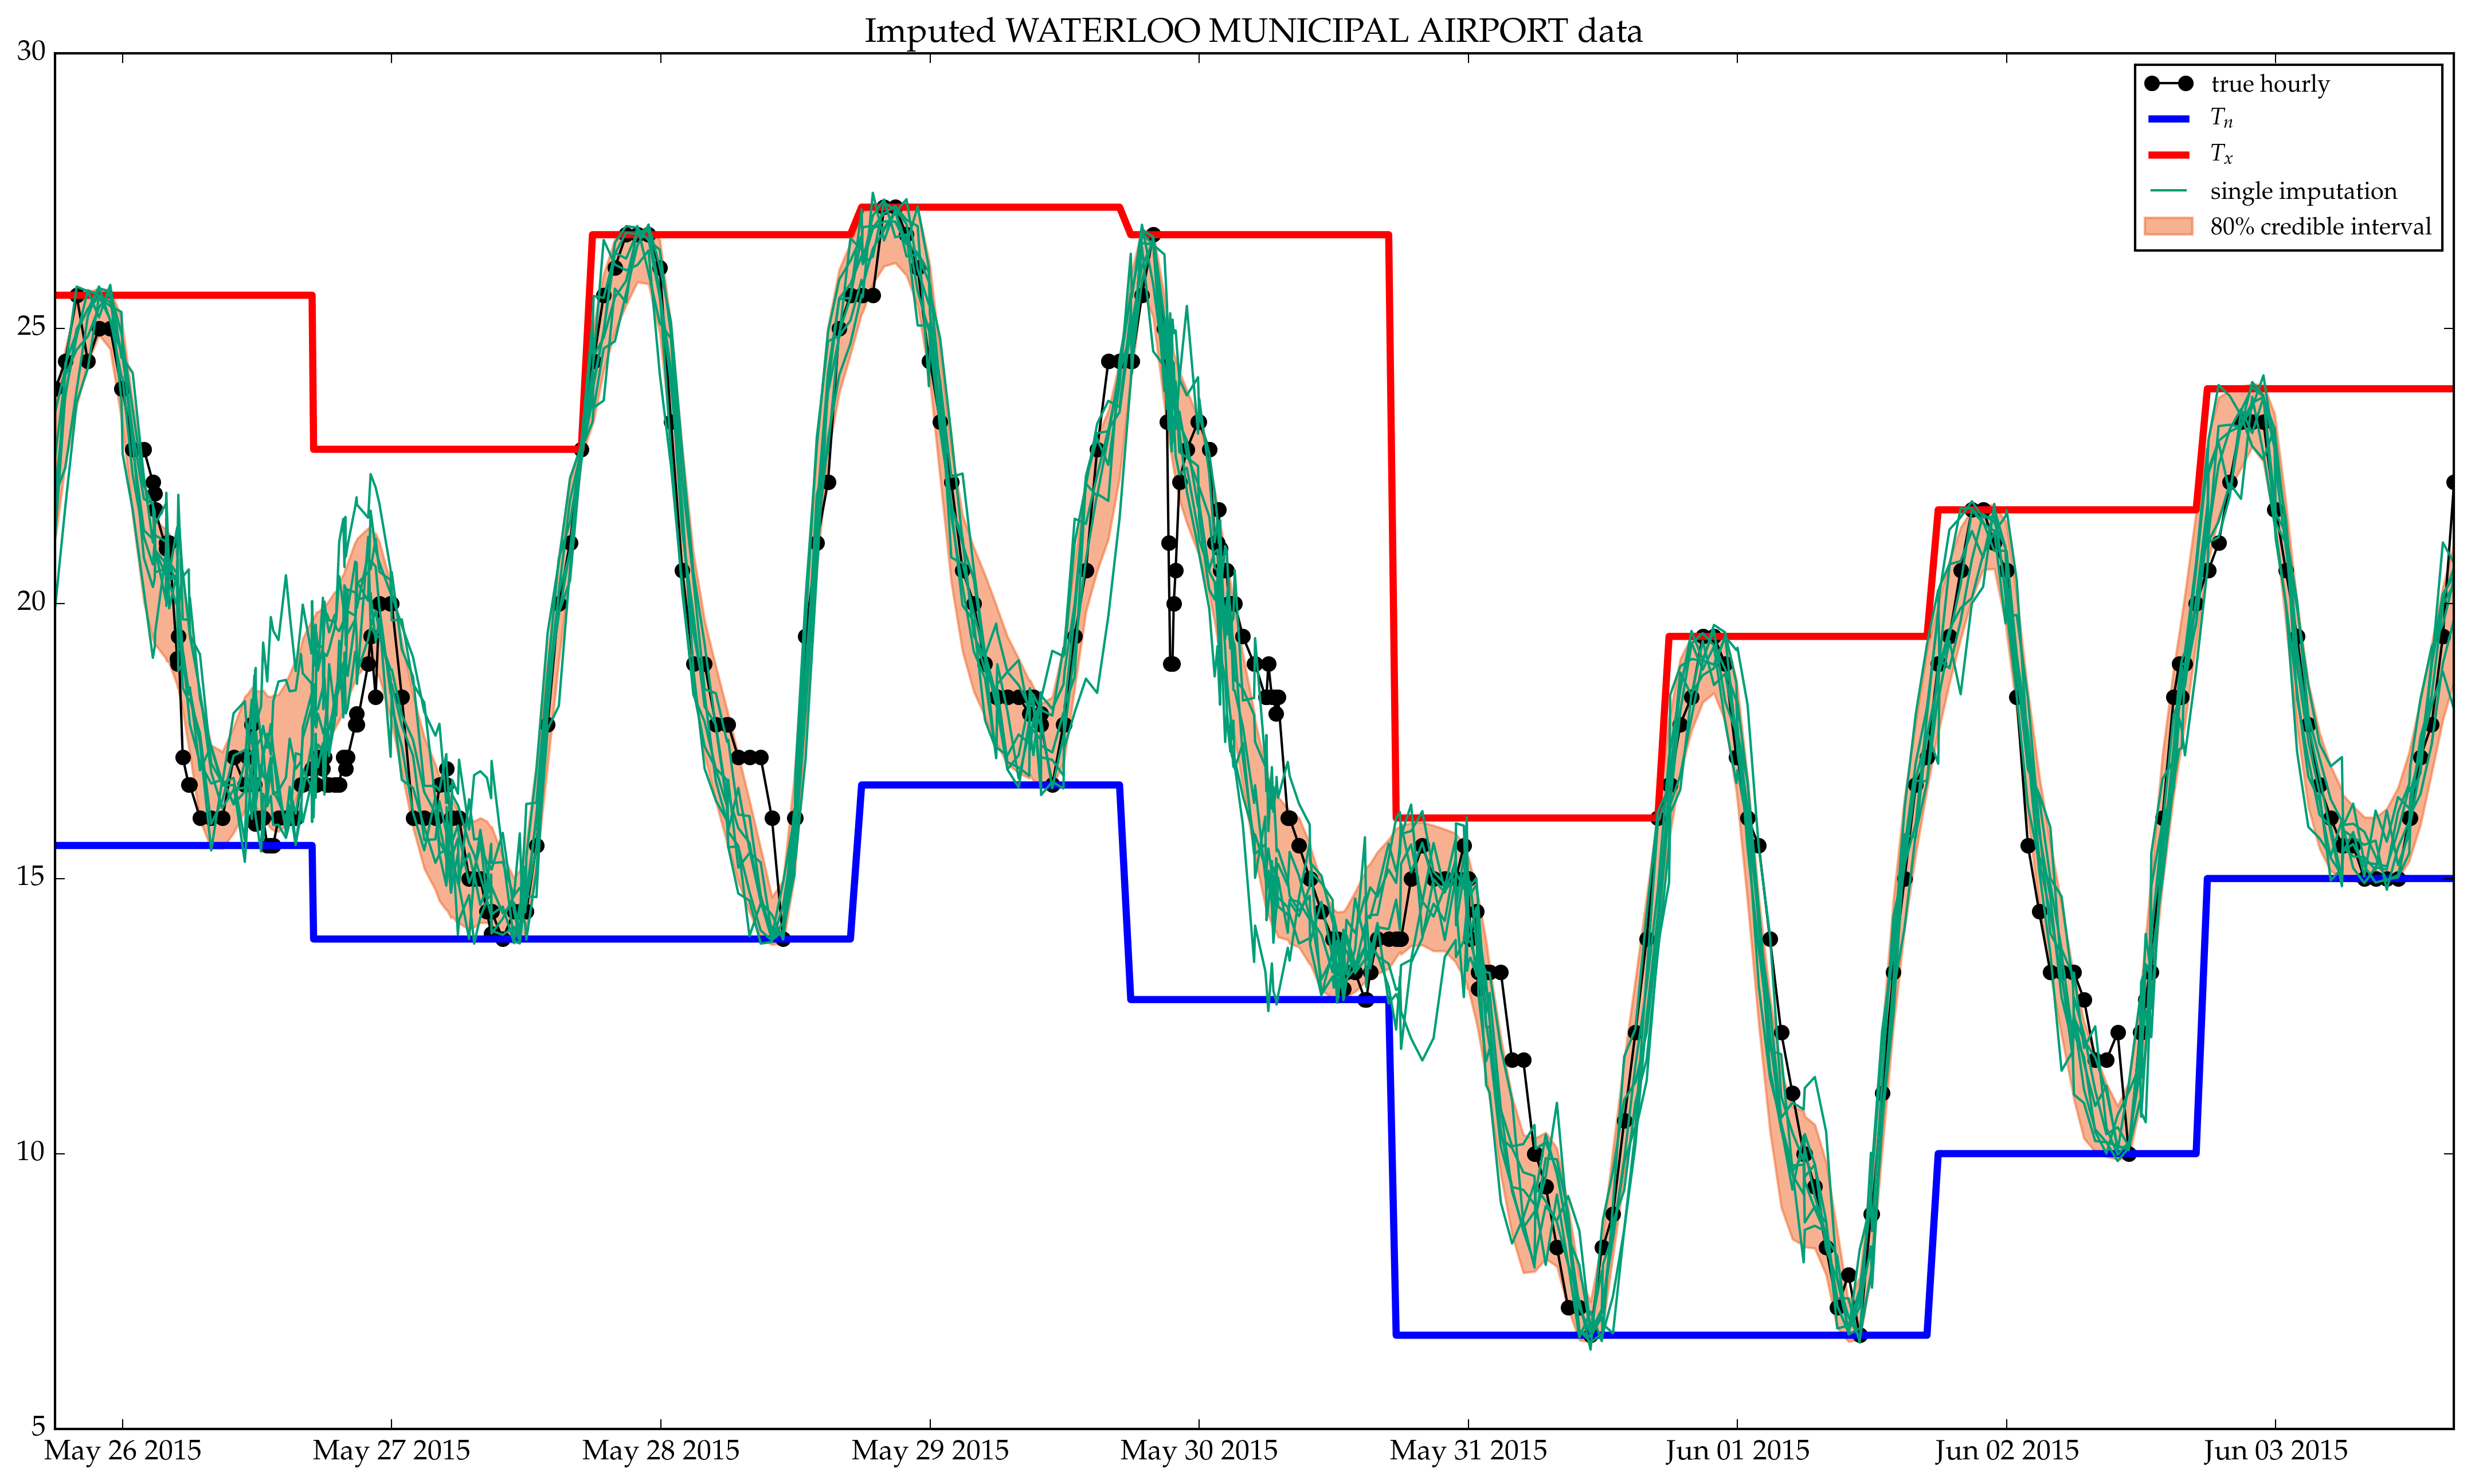

In [38]:
begin;
    temp_impute = get_temperatures_reparam(sim3)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    sorted_impute = sort(stacked_impute,1);
    nsamples=size(sorted_impute,1)
    # extract and 10th and 90th percentiles
    # of the imputations
    imputed_10 = sorted_impute[div(nsamples,10), :]
    imputed_90 = sorted_impute[nsamples-div(nsamples,10), :]
    ts = test_subset[:ts].values
    plt.plot(ts, test_subset[:temp].values, 
        color="black", "o-", label="true hourly")
    plt.plot(ts, test_subset[:Tn].values, 
        color="blue", linewidth=3, label=L"$T_n$")
    plt.plot(ts, test_subset[:Tx].values, 
        color="red", linewidth=3, label=L"$T_x$")
    plt.fill_between(ts, imputed_10, imputed_90, 
        color="#F16424", alpha=0.5, label=L"$80\%$ credible interval")
    plt.plot(ts, temp_impute[250,:,1],
        color="#009F77", label="single imputation")
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[250,:,i], color="#009F77")
    end
    for i in 2:size(temp_impute,3)
        plt.plot(ts, temp_impute[750,:,i], color="#009F77")
    end
    plt.legend(loc="best", fontsize="small")
    plt.gcf()[:set_size_inches](18.0, 10.0)
    plt.title(@sprintf("Imputed %s data", get(isdSubset[itest,:NAME])))
end;

In [69]:
mse(yhat::Vector,y::Vector) = mean((y.-yhat).^2)
verr(yhat::Vector,y::Vector) = var(y.-yhat)
begin
    temp_impute = get_temperatures_reparam(sim3)
    stacked_impute=vcat((temp_impute[:,:,i] for i in 1:size(temp_impute,3))...)
    temp_true = test_subset[:temp].values
    μ = vec(mean(stacked_impute, 1))
    println("E(var(predicted mean - predictive draw))=", mean(mse(μ, stacked_impute[i,:]) for i in 1:size(stacked_impute,1)))
    println("MSE(truth - predicted mean)=",mse(μ, temp_true))
end

E(var(predicted mean - predictive draw))=0.6802938872804132
MSE(truth - predicted mean)=1.434926895353342


# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Data-import-and-preprocessing" data-toc-modified-id="Data-import-and-preprocessing-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Data import and preprocessing</a></div><div class="lev1 toc-item"><a href="#Preparing-Test-Data" data-toc-modified-id="Preparing-Test-Data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Preparing Test Data</a></div><div class="lev1 toc-item"><a href="#Kernel-Specification" data-toc-modified-id="Kernel-Specification-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Kernel Specification</a></div><div class="lev1 toc-item"><a href="#Fitting-GP-on-training-data" data-toc-modified-id="Fitting-GP-on-training-data-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Fitting GP on training data</a></div><div class="lev2 toc-item"><a href="#Predicting-at-the-test-location" data-toc-modified-id="Predicting-at-the-test-location-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Predicting at the test location</a></div><div class="lev2 toc-item"><a href="#Prior-draws" data-toc-modified-id="Prior-draws-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Prior draws</a></div><div class="lev2 toc-item"><a href="#Predictive-draws" data-toc-modified-id="Predictive-draws-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Predictive draws</a></div><div class="lev2 toc-item"><a href="#Diagnostic-measures" data-toc-modified-id="Diagnostic-measures-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Diagnostic measures</a></div><div class="lev1 toc-item"><a href="#STAN-imputations" data-toc-modified-id="STAN-imputations-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>STAN imputations</a></div><div class="lev2 toc-item"><a href="#Model-specification" data-toc-modified-id="Model-specification-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Model specification</a></div><div class="lev2 toc-item"><a href="#preparing-Stan-data" data-toc-modified-id="preparing-Stan-data-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>preparing Stan data</a></div><div class="lev2 toc-item"><a href="#Running-MCMC" data-toc-modified-id="Running-MCMC-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Running MCMC</a></div><div class="lev2 toc-item"><a href="#Plotting-imputations" data-toc-modified-id="Plotting-imputations-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Plotting imputations</a></div><div class="lev2 toc-item"><a href="#Changed-softmax-definition" data-toc-modified-id="Changed-softmax-definition-5.5"><span class="toc-item-num">5.5&nbsp;&nbsp;</span>Changed softmax definition</a></div>